# Info
Name:  

    NAAMES_cld_comp

Purpose:  

    To compare the various cloud properties retrieved via different methods from NAAMES.
    Looking at the Nov. 17th, 2015 case
  
Input:

    none at command line
  
Output:

    figures and save files...
  
Keywords:

    none
  
Dependencies:

    - Sp_parameters.py : for Sp class definition, and for defining the functions used to build parameters
    - load_utils.py : for loading modis files
    - matplotlib
    - numpy
    - scipy : for saving and reading
    - math
    - os
    - gc
    - pdb
    - datetime
  
Needed Files:

  - file.rc : for consistent creation of look of matplotlib figures
  - 20151117_zen_cld_retrieved.mat: cloud retrieval file
  - MYD06_L2.A2015321.1540.006.2015322185040.hdf: MODIS file
  
Modification History:

    Written: Samuel LeBlanc, NASA Ames, Santa Cruz, CA, 2016-03-24
    Modified: 

# Import initial modules and default paths

In [1]:
%config InlineBackend.rc = {}
import matplotlib 
matplotlib.rc_file('C:\\Users\\sleblan2\\Research\\python_codes\\file.rc')
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import scipy.io as sio
import Sp_parameters as Sp
import hdf5storage as hs
import load_utils as lm

In [2]:
from mpl_toolkits.basemap import Basemap,cm

In [3]:
import write_utils as wu

In [4]:
%matplotlib notebook

C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [5]:
# set the basic directory path
fp='C:/Users/sleblan2/Research/NAAMES/'

# Load the various data

## Load the retrieved cloud properties from 4STAR

In [6]:
star = hs.loadmat(fp+'retrieve/20151117_zen_cld_retrieved.mat')

In [7]:
star.keys()

[u'tau', u'utc', u'ki', u'sza', u'lon', u'lat', u'phase', u'alt', u'ref']

<IPython.core.display.Javascript object>


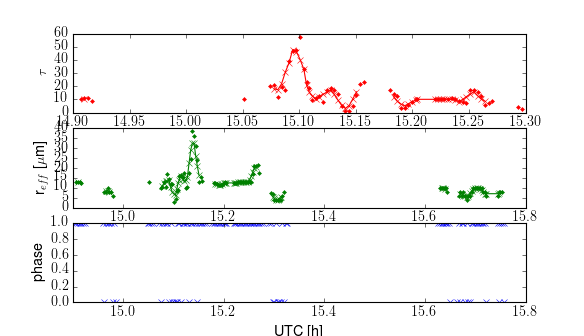

In [11]:
plt.figure()
plt.subplot(3,1,1)
plt.plot(star['utc'],star['tau'],'r.')
plt.plot(star['utc'],Sp.smooth(star['tau'],4,nan=False),'-xr')
plt.ylabel('$\\tau$')
plt.subplot(3,1,2)
plt.plot(star['utc'],star['ref'],'g.')
plt.plot(star['utc'],Sp.smooth(star['ref'],4,nan=False),'-xg')
plt.ylabel('r$_{eff}$ [$\\mu$m]')
plt.subplot(3,1,3)
plt.plot(star['utc'],star['phase'],'x')
plt.ylabel('phase')
plt.xlabel('UTC [h]')

In [8]:
star['tau'] = Sp.smooth(star['tau'],4,nan=False)
star['ref'] = Sp.smooth(star['ref'],4,nan=False)

In [9]:
star['tau'][star['tau']<1.0]=np.nan

C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


### Load the second day 4STAR retrieval

In [10]:
star2 = hs.loadmat(fp+'retrieve/20151123_zen_cld_retrieved.mat')

In [11]:
star2.keys()

[u'tau', u'utc', u'ki', u'sza', u'lon', u'lat', u'phase', u'alt', u'ref']

In [12]:
star2['tau'] = Sp.smooth(star2['tau'],4,nan=False)
star2['ref'] = Sp.smooth(star2['ref'],4,nan=False)
star2['tau'][star2['tau']<1.0]=np.nan

C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


## Load the MODIS file

In [13]:
myd3 = fp+'c130/20151117_flt/MYD03.A2015321.1540.006.2015322160400.hdf'
myd6 = fp+'c130/20151117_flt/MYD06_L2.A2015321.1540.006.2015322185040.hdf'

In [46]:
import load_utils as lu
reload(lu)

<module 'load_utils' from 'load_utils.py'>

In [51]:
modis,modis_dicts = lu.load_modis(myd3,myd6)

Outputting the Geo subdatasets:
0: [4060x2708] Scan Offset MODIS_Swath_Type_GEO (8-bit integer)
1: [4060x2708] Track Offset MODIS_Swath_Type_GEO (8-bit integer)
2: [4060x2708] Height Offset MODIS_Swath_Type_GEO (8-bit integer)
3: [2030x1354] Height MODIS_Swath_Type_GEO (16-bit integer)
4: [2030x1354] SensorZenith MODIS_Swath_Type_GEO (16-bit integer)
5: [2030x1354] SensorAzimuth MODIS_Swath_Type_GEO (16-bit integer)
6: [2030x1354] Range MODIS_Swath_Type_GEO (16-bit unsigned integer)
7: [2030x1354] SolarZenith MODIS_Swath_Type_GEO (16-bit integer)
8: [2030x1354] SolarAzimuth MODIS_Swath_Type_GEO (16-bit integer)
9: [2030x1354] Land/SeaMask MODIS_Swath_Type_GEO (8-bit unsigned integer)
10: [2030x1354] WaterPresent MODIS_Swath_Type_GEO (8-bit unsigned integer)
11: [2030x1354] gflags MODIS_Swath_Type_GEO (8-bit unsigned integer)
12: [2030x1354] Latitude (32-bit floating-point)
13: [2030x1354] Longitude (32-bit floating-point)
14: [4060x2708] Scan Offset (8-bit integer)
15: [4060x2708] Trac

### Load the second day MODIS file

In [15]:
myd3_2 = fp+'c130/20151123_flt05/MYD03.A2017103.1620.006.2017108173138.hdf'
myd6_2 = fp+'c130/20151123_flt05/MYD06_L2.A2017103.1620.006.2017108180657.hdf'

In [50]:
modis2,modis2_dicts = lu.load_modis(myd3_2,myd6_2)

Outputting the Geo subdatasets:
0: [4060x2708] Scan Offset MODIS_Swath_Type_GEO (8-bit integer)
1: [4060x2708] Track Offset MODIS_Swath_Type_GEO (8-bit integer)
2: [4060x2708] Height Offset MODIS_Swath_Type_GEO (8-bit integer)
3: [2030x1354] Height MODIS_Swath_Type_GEO (16-bit integer)
4: [2030x1354] SensorZenith MODIS_Swath_Type_GEO (16-bit integer)
5: [2030x1354] SensorAzimuth MODIS_Swath_Type_GEO (16-bit integer)
6: [2030x1354] Range MODIS_Swath_Type_GEO (16-bit unsigned integer)
7: [2030x1354] SolarZenith MODIS_Swath_Type_GEO (16-bit integer)
8: [2030x1354] SolarAzimuth MODIS_Swath_Type_GEO (16-bit integer)
9: [2030x1354] Land/SeaMask MODIS_Swath_Type_GEO (8-bit unsigned integer)
10: [2030x1354] WaterPresent MODIS_Swath_Type_GEO (8-bit unsigned integer)
11: [2030x1354] gflags MODIS_Swath_Type_GEO (8-bit unsigned integer)
12: [2030x1354] Latitude (32-bit floating-point)
13: [2030x1354] Longitude (32-bit floating-point)
14: [4060x2708] Scan Offset (8-bit integer)
15: [4060x2708] Trac

## Load the insitu probe liquid vs ice water content

In [17]:
help(lm.load_ict)

Help on function load_ict in module load_utils:

load_ict(fname, return_header=False, make_nan=True)
    Simple ict file loader
    created specifically to load the files from the iwg1 on board the G1 during TCAP, may work with others...
    inputs:
       fname: filename with full path
       return_header: (default set to False) if True, returns data, header in that form
       make_nan: (default set to True) if True, the values defined in the header to be missing data, usually -999, is changed to NaNs



In [18]:
wf = fp+'c130/20151117_flt/NAAMES-LARGE-WCM_C130_20151117_RA.ict'
wcm,wcm_head = lm.load_ict(wf,return_header=True)

('Date_UTC', 'TWC_gm_3', 'LWC1_gm_3', 'LWC2_gm_3')


<IPython.core.display.Javascript object>


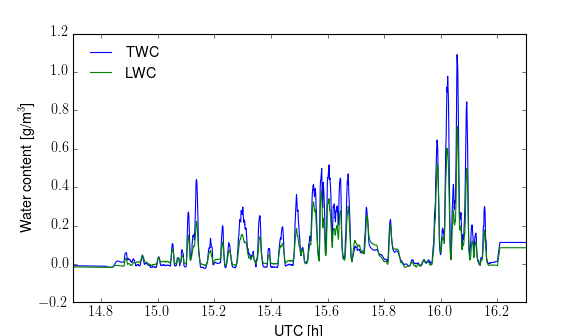

In [16]:
plt.figure()
plt.plot(wcm['Date_UTC']/3600,Sp.smooth(wcm['TWC_gm_3'],30),label='TWC')
plt.plot(wcm['Date_UTC']/3600,Sp.smooth(wcm['LWC1_gm_3'],30),label='LWC')
plt.ylabel('Water content [g/m$^3$]')
plt.xlabel('UTC [h]')
plt.xlim([14.7,16.3])
plt.legend(frameon=False,loc=2)

# Start plotting MODIS and the retrieved values

In [40]:
#set up a easy plotting function
def naames_map(ax=plt.gca()):
    m = Basemap(projection='stere',lon_0=-40,lat_0=50,
            llcrnrlon=-42, llcrnrlat=49.5,
            urcrnrlon=-37, urcrnrlat=51.5,resolution='h',ax=ax)
    m.drawcoastlines()
    #m.fillcontinents(color='#AAAAAA')
    m.drawstates()
    m.drawcountries()
    m.drawmeridians(np.linspace(-35,-45,11),labels=[0,0,0,1])
    m.drawparallels(np.linspace(45,55,11),labels=[1,0,0,0])
    return m

<IPython.core.display.Javascript object>


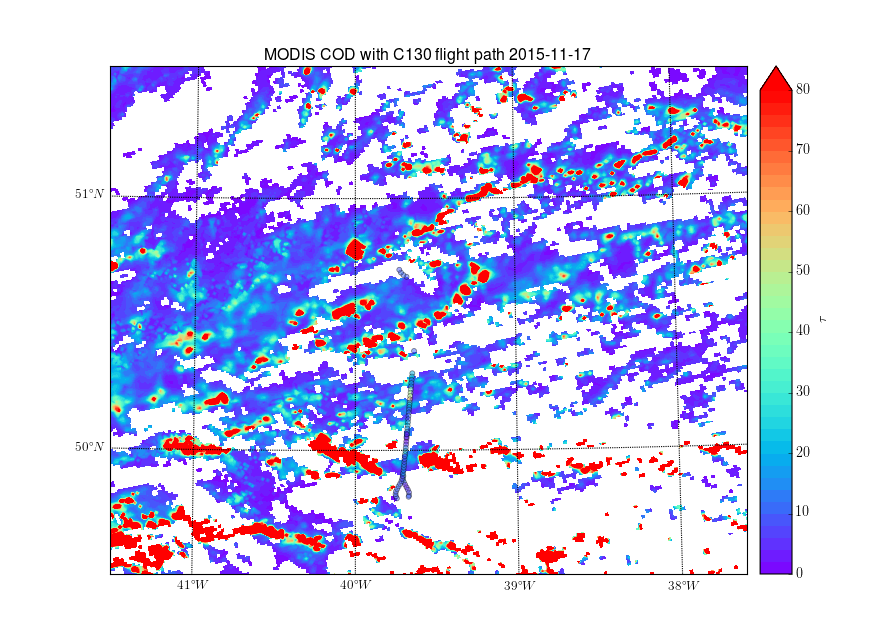

In [31]:
fig,ax = plt.subplots(1,1,figsize=(11,8))
m = naames_map(ax)
x,y = m(modis['lon'],modis['lat'])
clevels = np.linspace(0,80,41)

plt.title('MODIS COD with C130 flight path 2015-11-17')
cs1 = m.contourf(x,y,modis['tau'],clevels,cmap=plt.cm.rainbow,extend='max')
cbar = m.colorbar(cs1)
cbar.set_label('$\\tau$')

xx,yy = m(star['lon'],star['lat'])
m.scatter(xx,yy,c=star['tau'],cmap=plt.cm.rainbow,marker='o',vmin=clevels[0],vmax=clevels[-1],
          alpha=0.5,edgecolors='k',linewidth=0.65)
plt.savefig(fp+'plot/20151117_MODIS_4STAR_map_COD.png',dpi=600,transparent=True)

<IPython.core.display.Javascript object>


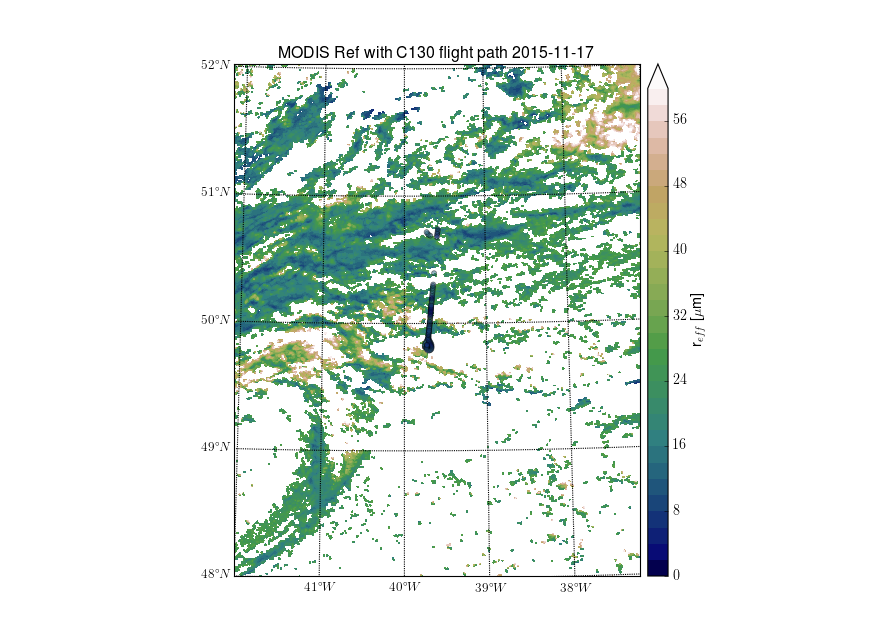

In [19]:
fig,ax = plt.subplots(1,1,figsize=(11,8))
m = naames_map(ax)
x,y = m(modis['lon'],modis['lat'])
clevels = np.linspace(0,60,31)
plt.title('MODIS Ref with C130 flight path 2015-11-17')
cs1 = m.contourf(x,y,modis['ref'],clevels,cmap=plt.cm.gist_earth,extend='max')
cbar = m.colorbar(cs1)
cbar.set_label('r$_{eff}$ [$\\mu$m]')

xx,yy = m(star['lon'],star['lat'])
m.scatter(xx,yy,c=star['ref'],cmap=plt.cm.gist_earth,marker='o',vmin=clevels[0],vmax=clevels[-1],
          alpha=0.5,edgecolors='k',linewidth=0.65)
plt.savefig(fp+'plot/20151117_MODIS_4STAR_map_ref.png',dpi=600,transparent=True)

Combine the MODIS map figures into a single tau and ref figure, for only the cloud phase of water

In [19]:
imod_wat = modis['phase']==1

In [20]:
mtau = modis['tau'].copy()
mref = modis['ref'].copy()

In [21]:
mtau[imod_wat] = np.nan
mref[imod_wat] = np.nan

<IPython.core.display.Javascript object>


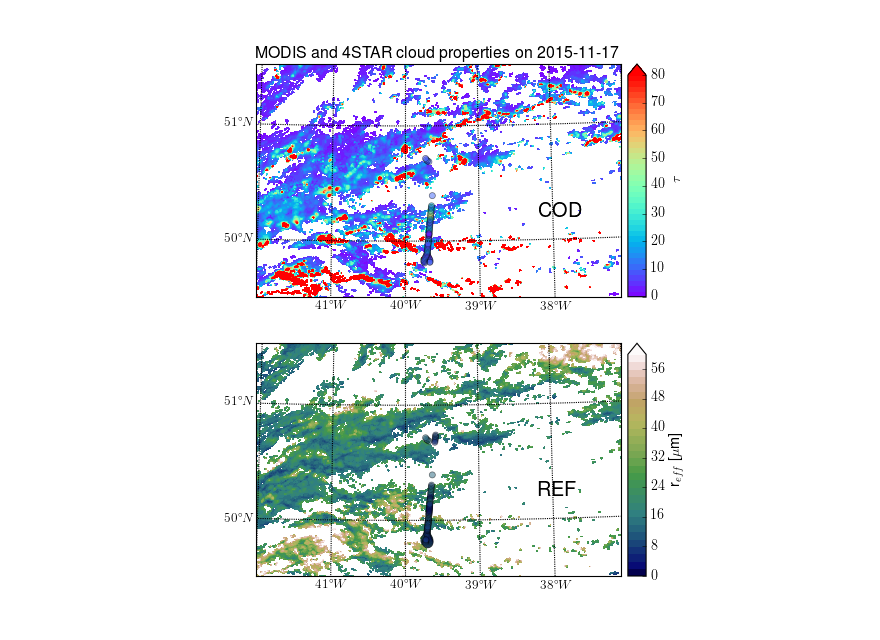

In [46]:
fig,ax = plt.subplots(2,1,figsize=(11,8))
ax = ax.ravel()
m = naames_map(ax[0])
x,y = m(modis['lon'],modis['lat'])
clevels = np.linspace(0,80,41)

ax[0].set_title('MODIS and 4STAR cloud properties on 2015-11-17')
cs1 = m.contourf(x,y,mtau,clevels,cmap=plt.cm.rainbow,extend='max')

x0,y0 = m(-38.2,50.2)
ax[0].text(x0,y0,'COD',fontsize=18)
cbar = m.colorbar(cs1)
cbar.set_label('$\\tau$')

xx,yy = m(star['lon'],star['lat'])
m.scatter(xx,yy,c=star['tau'],cmap=plt.cm.rainbow,marker='o',vmin=clevels[0],vmax=clevels[-1],
          alpha=0.5,edgecolors='k',linewidth=0.65,s=30)

m = naames_map(ax[1])
x,y = m(modis['lon'],modis['lat'])
clevels = np.linspace(0,60,31)
#ax[1].set_title('MODIS Ref with C130 flight path 2015-11-17')
cs1 = m.contourf(x,y,mref,clevels,cmap=plt.cm.gist_earth,extend='max')
ax[1].text(x0,y0,'REF',fontsize=18)
cbar = m.colorbar(cs1)
cbar.set_label('r$_{eff}$ [$\\mu$m]')

xx,yy = m(star['lon'],star['lat'])
m.scatter(xx,yy,c=star['ref'],cmap=plt.cm.gist_earth,marker='o',vmin=clevels[0],vmax=clevels[-1],
          alpha=0.5,edgecolors='k',linewidth=0.65,s=30)
plt.savefig(fp+'plot/20151117_MODIS_4STAR_map_cod_ref.png',dpi=600,transparent=True)


### Plot for the second day (11/23)

In [107]:
#set up a easy plotting function
def naames_map2(ax=plt.gca()):
    m = Basemap(projection='stere',lon_0=-40,lat_0=42.5,
            llcrnrlon=-44, llcrnrlat=41,
            urcrnrlon=-36, urcrnrlat=44.5,resolution='h',ax=ax)
    m.drawcoastlines()
    #m.fillcontinents(color='#AAAAAA')
    m.drawstates()
    m.drawcountries()
    m.drawmeridians(np.linspace(-35,-45,11),labels=[0,0,0,1])
    m.drawparallels(np.linspace(40,50,11),labels=[1,0,0,0])
    return m

In [22]:
imod2_wat = modis2['phase']==1
mtau2 = modis2['tau'].copy()
mref2 = modis2['ref'].copy()
#mtau2[imod2_wat] = np.nan
#mref2[imod2_wat] = np.nan

<IPython.core.display.Javascript object>


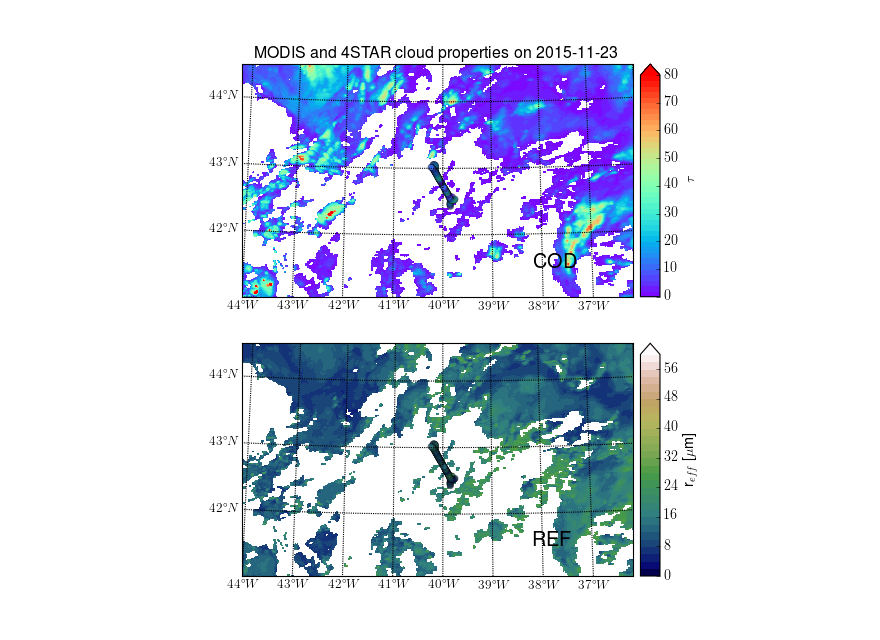

In [109]:
fig,ax = plt.subplots(2,1,figsize=(11,8))
ax = ax.ravel()
m = naames_map2(ax[0])
x,y = m(modis2['lon'],modis2['lat'])
clevels = np.linspace(0,80,41)

ax[0].set_title('MODIS and 4STAR cloud properties on 2015-11-23')
cs1 = m.contourf(x,y,mtau2,clevels,cmap=plt.cm.rainbow,extend='max')

x0,y0 = m(-38.2,41.5)
ax[0].text(x0,y0,'COD',fontsize=18)
cbar = m.colorbar(cs1)
cbar.set_label('$\\tau$')

xx,yy = m(star2['lon'],star2['lat'])
m.scatter(xx,yy,c=star2['tau'],cmap=plt.cm.rainbow,marker='o',vmin=clevels[0],vmax=clevels[-1],
          alpha=0.5,edgecolors='k',linewidth=0.65,s=30)

m = naames_map2(ax[1])
x,y = m(modis2['lon'],modis2['lat'])
clevels = np.linspace(0,60,31)
#ax[1].set_title('MODIS Ref with C130 flight path 2015-11-17')
cs1 = m.contourf(x,y,mref2,clevels,cmap=plt.cm.gist_earth,extend='max')
ax[1].text(x0,y0,'REF',fontsize=18)
cbar = m.colorbar(cs1)
cbar.set_label('r$_{eff}$ [$\\mu$m]')

xx,yy = m(star2['lon'],star2['lat'])
m.scatter(xx,yy,c=star2['ref'],cmap=plt.cm.gist_earth,marker='o',vmin=clevels[0],vmax=clevels[-1],
          alpha=0.5,edgecolors='k',linewidth=0.65,s=30)
plt.savefig(fp+'plot/20151123_MODIS_4STAR_map_cod_ref.png',dpi=600,transparent=True)


In [36]:
modis_dicts['phase']

{'ALGORITHMPACKAGEACCEPTANCEDATE': 'June 1997',
 'ALGORITHMPACKAGEMATURITYCODE': 'at-launch',
 'ALGORITHMPACKAGENAME': 'ATBD-MOD-04 and ATBD-MOD-05',
 'ALGORITHMPACKAGEVERSION': '2',
 'ALGORITHM_VERSION_CLOUD_PHASE_IR': '1',
 'ALGORITHM_VERSION_CLOUD_PROPERTY_VIS': '1',
 'ALGORITHM_VERSION_CLOUD_TOP_PROPERTY_IR': '1',
 'ANCILLARYINPUTPOINTER': 'MYD03.A2015321.1540.006.2015322160400.hdf',
 'ANCILLARYINPUTTYPE': 'Geolocation',
 'ASSOCIATEDINSTRUMENTSHORTNAME': 'MODIS',
 'ASSOCIATEDPLATFORMSHORTNAME': 'Aqua',
 'ASSOCIATEDSENSORSHORTNAME': 'MODIS',
 'AUTOMATICQUALITYFLAG': 'Passed',
 'AUTOMATICQUALITYFLAGEXPLANATION': 'Passed: >10% useable; Failed: <10% useable',
 'Cell_Across_Swath_Sampling': '1, 1354, 1',
 'Cell_Along_Swath_Sampling': '1, 2030, 1',
 'CirrusCloudDetectedPct_IR': '   41.25',
 'Clear_Sky_Restoral_Status': 'y',
 'CloudPhaseUncertainPct_IR': '   35.02',
 'Collection_4_Phase_Used': 'n',
 'DAYNIGHTFLAG': 'Day',
 'DESCRREVISION': '6.0',
 'EASTBOUNDINGCOORDINATE': '-24.3883177545

<IPython.core.display.Javascript object>


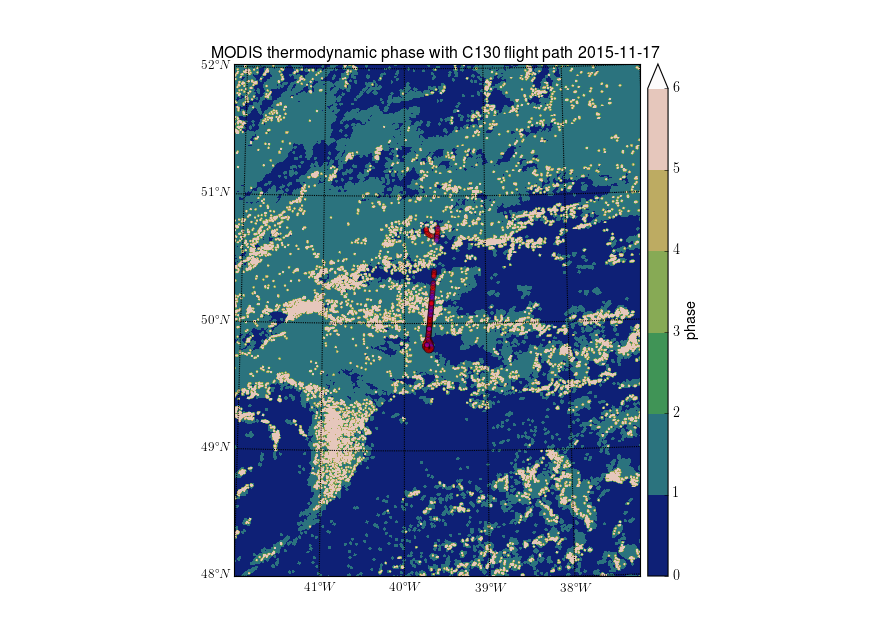

In [23]:
fig,ax = plt.subplots(1,1,figsize=(11,8))
m = naames_map(ax)
x,y = m(modis['lon'],modis['lat'])
clevels = np.linspace(0,6,7)
plt.title('MODIS thermodynamic phase with C130 flight path 2015-11-17')
cs1 = m.contourf(x,y,modis['phase'],clevels,cmap=plt.cm.gist_earth,extend='max')
cbar = m.colorbar(cs1)
cbar.set_label('phase')

xx,yy = m(star['lon'],star['lat'])
m.scatter(xx,yy,c=star['phase'],cmap=plt.cm.rainbow,marker='o',vmin=0,vmax=1,
          alpha=0.5,edgecolors='k',linewidth=0.65)

plt.savefig(fp+'plot/20151117_MODIS_4STAR_map_phase.png',dpi=600,transparent=True)

## Subset the MODIS values to match the flight path

In [23]:
import map_utils as mu

In [24]:
mod_ind = mu.map_ind(modis['lon'],modis['lat'],star['lon'],star['lat'])

Running through flight track: [########################################]100% -- Done! 


In [25]:
mod_ind.shape

(2L, 340L)

In [26]:
modis['lat'].shape

(2030L, 1354L)

In [51]:
star['lat'].shape

(340L, 1L)

In [27]:
star['tau'][star['tau']<1.0] = np.nan

C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


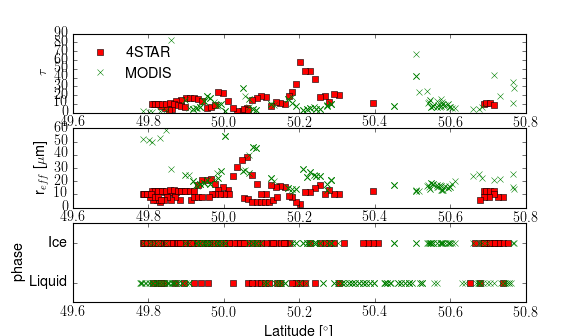

In [53]:
plt.figure()
ax = plt.subplot(3,1,1)
plt.plot(star['lat'],star['tau'],'rs',label='4STAR')
plt.plot(modis['lat'][mod_ind[0,:],mod_ind[1,:]],mtau[mod_ind[0,:],mod_ind[1,:]],'gx',label='MODIS')
plt.legend(frameon=False,numpoints=1,loc=0)
plt.ylabel('$\\tau$')
plt.subplot(3,1,2,sharex=ax)
plt.plot(star['lat'],star['ref'],'rs')
plt.plot(modis['lat'][mod_ind[0,:],mod_ind[1,:]],mref[mod_ind[0,:],mod_ind[1,:]],'gx',label='MODIS')
plt.ylabel('r$_{eff}$ [$\\mu$m]')
ax3 = plt.subplot(3,1,3,sharex=ax)
plt.plot(star['lat'],star['phase'],'rs')
plt.plot(modis['lat'][mod_ind[0,:],mod_ind[1,:]],modis['phase'][mod_ind[0,:],mod_ind[1,:]]-1,'gx',label='MODIS')
plt.ylim([-0.5,1.5])
plt.yticks([0,1])
ax3.set_yticklabels(['Liquid','Ice'])
plt.ylabel('phase')
plt.xlabel('Latitude [$^\circ$]')
plt.savefig(fp+'plot/20151117_cld_retr_vs_MODIS.png',transparent=True,dpi=600)

<IPython.core.display.Javascript object>


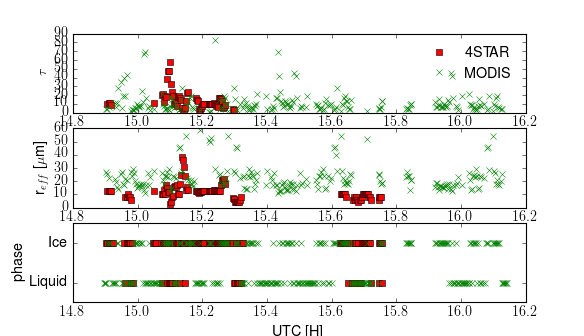

In [31]:
plt.figure()
ax = plt.subplot(3,1,1)
plt.plot(star['utc'],star['tau'],'rs',label='4STAR')
plt.plot(star['utc'],modis['tau'][mod_ind[0,:],mod_ind[1,:]],'gx',label='MODIS')
plt.legend(frameon=False,numpoints=1,loc=0)
plt.ylabel('$\\tau$')
plt.subplot(3,1,2,sharex=ax)
plt.plot(star['utc'],star['ref'],'rs')
plt.plot(star['utc'],modis['ref'][mod_ind[0,:],mod_ind[1,:]],'gx',label='MODIS')
plt.ylabel('r$_{eff}$ [$\\mu$m]')
ax3 = plt.subplot(3,1,3,sharex=ax)
plt.plot(star['utc'],star['phase'],'rs')
plt.plot(star['utc'],modis['phase'][mod_ind[0,:],mod_ind[1,:]]-1,'gx',label='MODIS')
plt.ylim([-0.5,1.5])
plt.yticks([0,1])
ax3.set_yticklabels(['Liquid','Ice'])
plt.ylabel('phase')
plt.xlabel('UTC [H]')
plt.savefig(fp+'plot/20151117_cld_retr_vs_MODIS_time.png',transparent=True,dpi=600)

<IPython.core.display.Javascript object>


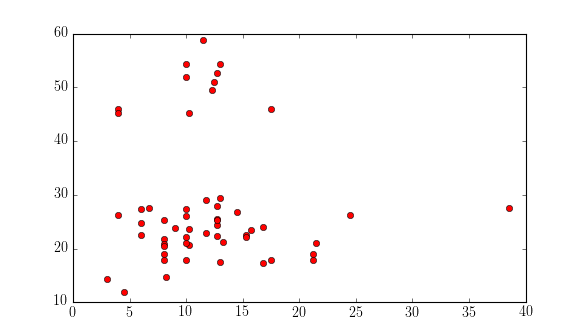

In [31]:
plt.figure()
plt.plot(star['ref'],modis['ref'][mod_ind[0,:],mod_ind[1,:]],'or')

In [36]:
import plotting_utils as pu

<IPython.core.display.Javascript object>


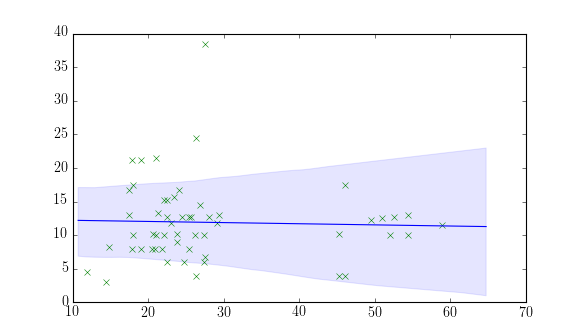

(array([ 12.38606956,  -0.01699016]), array([ 2.05949017,  0.0675078 ]))

In [38]:
plt.figure()
plt.plot(modis['ref'][mod_ind[0,:],mod_ind[1,:]],star['ref'],'xg')
pu.plot_lin(modis['ref'][mod_ind[0,:],mod_ind[1,:]],star['ref'])

### Subset the modis to 4STAR for the second day

In [28]:
mod_ind2 = mu.map_ind(modis2['lon'],modis2['lat'],star2['lon'],star2['lat'])

Running through flight track: [########################################]100% -- Done! 


In [29]:
star2['tau'][star2['tau']<1.0] = np.nan

C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [41]:
len(modis2['ref'][mod_ind2[0,:],mod_ind2[1,:]])

329

In [42]:
modis.keys()

['tau',
 'etau',
 'multi_layer',
 'sza',
 'lon',
 'qa',
 'phase',
 'eref',
 'lat',
 'ref']

<IPython.core.display.Javascript object>


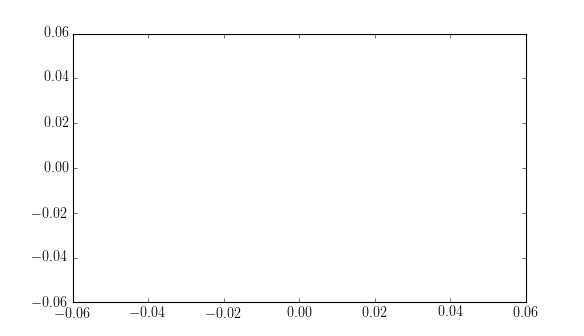

TypeError: Expected x and y length > 2

In [39]:
plt.figure()
plt.plot(modis2['ref'][mod_ind2[0,:],mod_ind2[1,:]],star2['ref'],'xg')
#pu.plot_lin(modis2['ref'][mod_ind2[0,:],mod_ind2[1,:]],star2['ref'])

## Load aicraft files

In [117]:
fh = fp+'data_other/housekeeping/'
rh = 'R0'
hsk,hsk_h = lu.load_ict(fh+'NAAMES-Hskping_c130_{d}_{r}.ict'.format(d='20151117',r=rh),return_header=True)
hsk2,hsk2_h = lu.load_ict(fh+'NAAMES-Hskping_c130_{d}_{r}.ict'.format(d='20151123',r=rh),return_header=True)

('Start_UTC', 'Day_Of_Year', 'Latitude', 'Longitude', 'GPS_Altitude', 'Pressure_Altitude', 'Ground_Speed', 'True_Air_Speed', 'Indicated_Air_Speed', 'Mach_Number', 'Vertical_Speed', 'True_Heading', 'Track_Angle', 'Drift_Angle', 'Pitch_Angle', 'Roll_Angle', 'Static_Air_Temp', 'Potential_Temp', 'Dew_Point', 'Total_Air_Temp', 'IR_Surf_Temp', 'Static_Pressure', 'Cabin_Pressure', 'Wind_Speed', 'Wind_Direction', 'Solar_Zenith_Angle', 'Aircraft_Sun_Elevation', 'Sun_Azimuth', 'Aircraft_Sun_Azimuth', 'Mixing_Ratio', 'Part_Press_Water_Vapor', 'Sat_Vapor_Press_H2O', 'Sat_Vapor_Press_Ice', 'Relative_Humidity')
('Start_UTC', 'Day_Of_Year', 'Latitude', 'Longitude', 'GPS_Altitude', 'Pressure_Altitude', 'Ground_Speed', 'True_Air_Speed', 'Indicated_Air_Speed', 'Mach_Number', 'Vertical_Speed', 'True_Heading', 'Track_Angle', 'Drift_Angle', 'Pitch_Angle', 'Roll_Angle', 'Static_Air_Temp', 'Potential_Temp', 'Dew_Point', 'Total_Air_Temp', 'IR_Surf_Temp', 'Static_Pressure', 'Cabin_Pressure', 'Wind_Speed', 'Win

In [118]:
hsk = lu.recarray_to_dict(hsk)
hsk2 = lu.recarray_to_dict(hsk2)

## Load the RSP

In [121]:
import load_utils as lu
from write_utils import nearest_neighbor

In [111]:
fr = fp+'data_other/RSP/'
rr = 'R1'

In [113]:
rsp,rsp_h = lu.load_ict(fr+'NAAMES-RSP-WTRCLD_C130_{d}_{r}.ict'.format(d='20151117',r=rr),return_header=True)
rsp2,rsp2_h = lu.load_ict(fr+'NAAMES-RSP-WTRCLD_C130_{d}_{r}.ict'.format(d='20151123',r=rr),return_header=True)

('UTC_start', 'UTC_stop', 'Lat', 'Lon', 'CTH_stereo', 'COT', 'Reff', 'Reff_unc', 'Veff', 'Veff_unc', 'COT_rad_1590', 'Reff_rad_1590', 'COT_rad_2260', 'Reff_rad_2260')
('UTC_start', 'UTC_stop', 'Lat', 'Lon', 'CTH_stereo', 'COT', 'Reff', 'Reff_unc', 'Veff', 'Veff_unc', 'COT_rad_1590', 'Reff_rad_1590', 'COT_rad_2260', 'Reff_rad_2260')


In [114]:
rsp = lu.recarray_to_dict(rsp)
rsp2 = lu.recarray_to_dict(rsp2)

In [122]:
rsp['alt'] = nearest_neighbor(hsk['Start_UTC'],hsk['GPS_Altitude'],rsp['UTC_start']/3600.0,dist=1.0/3600.0)

In [123]:
rsp2['alt'] = nearest_neighbor(hsk2['Start_UTC'],hsk2['GPS_Altitude'],rsp2['UTC_start']/3600.0,dist=1.0/3600.0)

## Now compare MODIS vs. 4STAR with bean plots

In [54]:
import plotting_utils as pu

<IPython.core.display.Javascript object>


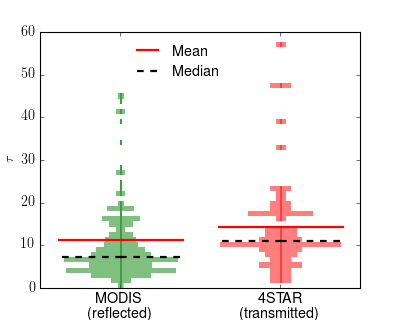

C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\matplotlib\axes\_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [55]:
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[0,60],xlim=[-0.5,1.5])
ax1.set_ylabel('$\\tau$')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['MODIS\n(reflected)','4STAR\n(transmitted)'])
pu.plot_vert_hist(fig,ax1,modis['tau'][mod_ind[0,:],mod_ind[1,:]],0,[0,60],legend=True,onlyhist=False,loc=2,color='g',bins=50)
pu.plot_vert_hist(fig,ax1,star['tau'],1,[0,60],legend=True,color='r',bins=50)
plt.savefig(fp+'plot/20151117_COD_bean_modis_4star.png',transparent=True,dpi=600)

In [56]:
len(np.unique(modis['tau'][mod_ind[0,:],mod_ind[1,:]])),len(star['tau'])

(228, 340)

<IPython.core.display.Javascript object>


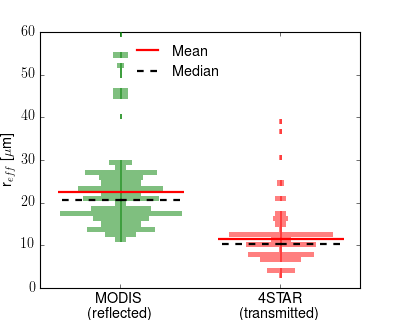

In [57]:
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[0,60],xlim=[-0.5,1.5])
ax1.set_ylabel('r$_{eff}$ [$\\mu$m]')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['MODIS\n(reflected)','4STAR\n(transmitted)'])
pu.plot_vert_hist(fig,ax1,modis['ref'][mod_ind[0,:],mod_ind[1,:]],0,[0,60],legend=True,onlyhist=False,loc=2,color='g',bins=50)
pu.plot_vert_hist(fig,ax1,star['ref'],1,[0,60],legend=True,color='r',bins=50)
plt.savefig(fp+'plot/20151117_ref_bean_modis_4star.png',transparent=True,dpi=600)

<IPython.core.display.Javascript object>


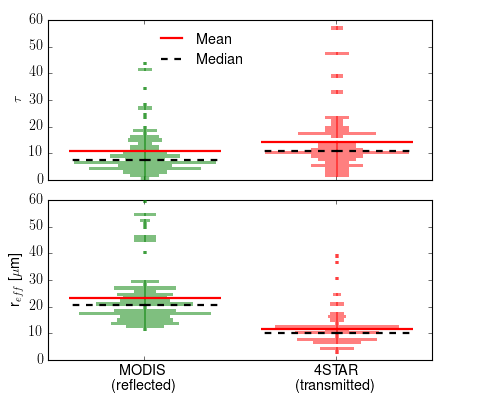

In [73]:
fig = plt.figure(figsize=(6,5))
#ax1,ax2 = ax.ravel()
ax1 = fig.add_axes([0.1,0.55,0.8,0.4],ylim=[0,60],xlim=[-0.5,1.5])
ax1.set_ylabel('$\\tau$')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['',''])#['MODIS\n(reflected)','4STAR\n(transmitted)'])
pu.plot_vert_hist(fig,ax1,mtau[mod_ind[0,:],mod_ind[1,:]],0,[0,60],legend=True,onlyhist=False,loc=2,color='g',bins=50)
pu.plot_vert_hist(fig,ax1,star['tau'],1,[0,60],legend=True,color='r',bins=50)
#plt.savefig(fp+'plot/20151117_COD_bean_modis_4star.png',transparent=True,dpi=600)

#fig = plt.figure(figsize=(5,4))
ax2 = fig.add_axes([0.1,0.1,0.8,0.4],ylim=[0,60],xlim=[-0.5,1.5])
ax2.set_ylabel('r$_{eff}$ [$\\mu$m]')
ax2.set_xticks([0,1])
ax2.set_xticklabels(['MODIS\n(reflected)','4STAR\n(transmitted)'])
pu.plot_vert_hist(fig,ax2,mref[mod_ind[0,:],mod_ind[1,:]],0,[0,60],legend=False,onlyhist=False,loc=2,color='g',bins=50)
pu.plot_vert_hist(fig,ax2,star['ref'],1,[0,60],legend=True,color='r',bins=50)
plt.savefig(fp+'plot/20151117_ref_tau_bean_modis_4star.png',transparent=True,dpi=600)

In [126]:
rsp['UTC_start'][1]

42039.099999999999

In [129]:
irsp = (rsp['UTC_start']/3600.0>14.6)&(rsp['UTC_start']/3600.0<16.55)&(rsp['COT']<60)

C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


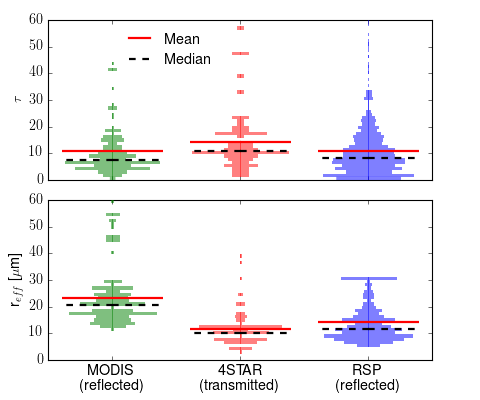

In [131]:
fig = plt.figure(figsize=(6,5))
#ax1,ax2 = ax.ravel()
ax1 = fig.add_axes([0.1,0.55,0.8,0.4],ylim=[0,60],xlim=[-0.5,2.5])
ax1.set_ylabel('$\\tau$')
ax1.set_xticks([0,1,2])
ax1.set_xticklabels(['',''])#['MODIS\n(reflected)','4STAR\n(transmitted)'])
pu.plot_vert_hist(fig,ax1,mtau[mod_ind[0,:],mod_ind[1,:]],0,[0,60],legend=True,onlyhist=False,loc=2,color='g',bins=50)
pu.plot_vert_hist(fig,ax1,star['tau'],1,[0,60],legend=True,color='r',bins=50)
pu.plot_vert_hist(fig,ax1,rsp['COT'][irsp],2,[0,60],legend=True,color='b',bins=50)
#plt.savefig(fp+'plot/20151117_COD_bean_modis_4star.png',transparent=True,dpi=600)

#fig = plt.figure(figsize=(5,4))
ax2 = fig.add_axes([0.1,0.1,0.8,0.4],ylim=[0,60],xlim=[-0.5,2.5])
ax2.set_ylabel('r$_{eff}$ [$\\mu$m]')
ax2.set_xticks([0,1,2])
ax2.set_xticklabels(['MODIS\n(reflected)','4STAR\n(transmitted)','RSP\n(reflected)'])
pu.plot_vert_hist(fig,ax2,mref[mod_ind[0,:],mod_ind[1,:]],0,[0,60],legend=False,onlyhist=False,loc=2,color='g',bins=50)
pu.plot_vert_hist(fig,ax2,star['ref'],1,[0,60],legend=True,color='r',bins=50)
pu.plot_vert_hist(fig,ax2,rsp['Reff'][irsp],2,[0,60],legend=True,color='b',bins=50)
plt.savefig(fp+'plot/20151117_ref_tau_bean_modis_4star_rsp.png',transparent=True,dpi=600)

In [124]:
rsp.keys()

['COT_rad_1590',
 'Reff_rad_2260',
 'COT',
 'Reff_rad_1590',
 'UTC_stop',
 'Lon',
 'Veff_unc',
 'CTH_stereo',
 'Reff_unc',
 'COT_rad_2260',
 'Lat',
 'UTC_start',
 'Veff',
 'alt',
 'Reff']

### Bean plots of properties for second day

In [105]:
imod2_wat = modis2['phase']==1
mtau2 = modis2['tau'].copy()
mref2 = modis2['ref'].copy()
mtau2[imod2_wat] = np.nan
mref2[imod2_wat] = np.nan

<IPython.core.display.Javascript object>


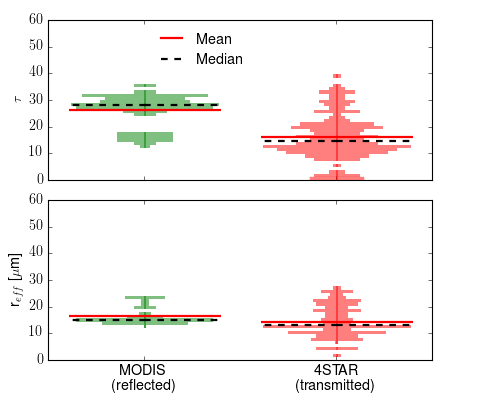

In [106]:
fig = plt.figure(figsize=(6,5))
#ax1,ax2 = ax.ravel()
ax1 = fig.add_axes([0.1,0.55,0.8,0.4],ylim=[0,60],xlim=[-0.5,2.5])
ax1.set_ylabel('$\\tau$')
ax1.set_xticks([0,1,2])
ax1.set_xticklabels(['',''])#['MODIS\n(reflected)','4STAR\n(transmitted)'])
pu.plot_vert_hist(fig,ax1,mtau2[mod_ind2[0,:],mod_ind2[1,:]],0,[0,60],legend=True,onlyhist=False,loc=2,color='g',bins=50)
pu.plot_vert_hist(fig,ax1,star2['tau'],1,[0,60],legend=True,color='r',bins=50)
pu.plot_vert_hist(fig,ax1,rsp2['COT'][irsp2],2,[0,60],legend=True,color='b',bins=50)
#plt.savefig(fp+'plot/20151117_COD_bean_modis_4star.png',transparent=True,dpi=600)

#fig = plt.figure(figsize=(5,4))
ax2 = fig.add_axes([0.1,0.1,0.8,0.4],ylim=[0,60],xlim=[-0.5,2.5])
ax2.set_ylabel('r$_{eff}$ [$\\mu$m]')
ax2.set_xticks([0,1,2])
ax2.set_xticklabels(['MODIS\n(reflected)','4STAR\n(transmitted)','RSP\n(reflected)'])
pu.plot_vert_hist(fig,ax2,mref2[mod_ind2[0,:],mod_ind2[1,:]],0,[0,60],legend=False,onlyhist=False,loc=2,color='g',bins=50)
pu.plot_vert_hist(fig,ax2,star2['ref'],1,[0,60],legend=True,color='r',bins=50)
pu.plot_vert_hist(fig,ax2,rsp2['Reff'][irsp2],2,[0,60],legend=True,color='b',bins=50)
plt.savefig(fp+'plot/20151123_ref_tau_bean_modis_4star.png',transparent=True,dpi=600)

In [137]:
irsp2 = (rsp2['UTC_start']/3600.0>12.1)&(rsp2['UTC_start']/3600.0<12.43)&(rsp2['COT']<60)

C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


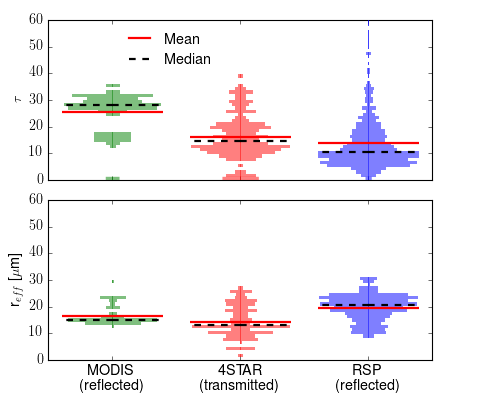

In [139]:
fig = plt.figure(figsize=(6,5))
#ax1,ax2 = ax.ravel()
ax1 = fig.add_axes([0.1,0.55,0.8,0.4],ylim=[0,60],xlim=[-0.5,2.5])
ax1.set_ylabel('$\\tau$')
ax1.set_xticks([0,1,2])
ax1.set_xticklabels(['',''])#['MODIS\n(reflected)','4STAR\n(transmitted)'])
pu.plot_vert_hist(fig,ax1,mtau2[mod_ind2[0,:],mod_ind2[1,:]],0,[0,60],legend=True,onlyhist=False,loc=2,color='g',bins=50)
pu.plot_vert_hist(fig,ax1,star2['tau'],1,[0,60],legend=True,color='r',bins=50)
pu.plot_vert_hist(fig,ax1,rsp2['COT'][irsp2],2,[0,60],legend=True,color='b',bins=50)
#plt.savefig(fp+'plot/20151117_COD_bean_modis_4star.png',transparent=True,dpi=600)

#fig = plt.figure(figsize=(5,4))
ax2 = fig.add_axes([0.1,0.1,0.8,0.4],ylim=[0,60],xlim=[-0.5,2.5])
ax2.set_ylabel('r$_{eff}$ [$\\mu$m]')
ax2.set_xticks([0,1,2])
ax2.set_xticklabels(['MODIS\n(reflected)','4STAR\n(transmitted)','RSP\n(reflected)'])
pu.plot_vert_hist(fig,ax2,mref2[mod_ind2[0,:],mod_ind2[1,:]],0,[0,60],legend=False,onlyhist=False,loc=2,color='g',bins=50)
pu.plot_vert_hist(fig,ax2,star2['ref'],1,[0,60],legend=True,color='r',bins=50)
pu.plot_vert_hist(fig,ax2,rsp2['Reff'][irsp2],2,[0,60],legend=True,color='b',bins=50)
plt.savefig(fp+'plot/20151123_ref_tau_bean_modis_4star_rsp.png',transparent=True,dpi=600)

# Now prepare a subsection of retrieved values to be saved in ict

## create the dicts for writing to ict

In [60]:
star.keys()

[u'tau', u'utc', u'ki', u'sza', u'lon', u'lat', u'phase', u'alt', u'ref']

In [230]:
d_dict =  {'utc':{'data':star['utc'],'unit':'hours from midnight UTC',
                     'long_description':'Fractional hours starting a midnight, continuous'},
          'COD':{'data':star['tau'],'unit':'None','format':'.1f',
                 'long_description':'Cloud Optical Depth of the cloud above the Aircraft'},
          'REF':{'data':star['ref'],'unit':'microns','format':'.1f',
                 'long_description':'Cloud particle effective radius, pertains to liquid cloud drops and ice crystals'},
          'PHASE':{'data':star['phase'],'unit':'None','format':'.0f',
                   'long_description':'Thermodynamic phase of cloud above, 0: pure liquid cloud, 1: pure ice cloud, mixed phase not retrieved'},
          'LAT':{'data':star['lat'],'unit':'Degrees','format':'.6f',
                 'long_description':'Aircraft position latitude (North positive)'},
          'LON':{'data':star['lon'],'unit':'Degrees','format':'.6f',
                 'long_description':'Aircraft position longitude (East positive)'},
          'ALT':{'data':star['alt'],'unit':'meter','format':'.1f',
                 'long_description':'Aircraft altitude'},
          'SZA':{'data':star['sza'],'unit':'Degrees','format':'.2f',
                 'long_description':'Solar Zenith Angle, angle of the sun between it and zenith'}
          }

In [231]:
h_dict ={'PI':'Jens Redemann',
         'Institution':'NASA Ames Research Center',
         'Instrument':'4STAR',
         'campaign':'NAAMES #1',
         'special_comments':'Preliminary retrieved cloud properties data',
         'PI_contact':'Samuel LeBlanc, samuel.leblanc@nasa.gov',
         'platform':'C130',
         'location':"based out of St-John's, NL, Canada, actual location of C130 described by lat and lon below",
         'instrument_info':'Retrieved products from the 4STAR zenith radiance measurements',
         'data_info':'For references see LeBlanc et al.(2015) AMT, doi:10.5194/amt-8-1361-2015',
         'time_interval':10.0,
         'uncertainty':'Preliminary 7% in REF and 5% in COD',
         'DM_contact':'Samuel LeBlanc, samuel.leblanc@nasa.gov',
         'project_info':'NAAMES field mission',
         'stipulations':'Prior OK from PI',
         'rev_comments':"""RA: preliminary retrieved values, may be subject to multiple errors
    including due to clouds influencing presumed surface albedo, non-homogeneous clouds, or mixed phase clouds"""
        }

In [232]:
order=['LAT','LON','ALT','SZA','COD','REF','PHASE']

### Redo for the second day

In [176]:
star2['lat']

array([[ 47.6186],
       [ 47.6186],
       [ 47.6186],
       [ 47.6186],
       [ 47.6186],
       [ 47.6186],
       [ 47.6186],
       [ 47.6186],
       [ 42.4813],
       [ 42.475 ],
       [ 42.4682],
       [ 42.4567],
       [ 42.4449],
       [ 42.4339],
       [ 42.4244],
       [ 42.4174],
       [ 42.412 ],
       [ 42.4095],
       [ 42.4103],
       [ 42.4145],
       [ 42.4204],
       [ 42.4287],
       [ 42.4383],
       [ 42.4487],
       [ 42.4595],
       [ 42.4692],
       [ 42.4797],
       [ 42.49  ],
       [ 42.5003],
       [ 42.511 ],
       [ 42.5208],
       [ 42.5315],
       [ 42.5423],
       [ 42.5528],
       [ 42.5631],
       [ 42.5723],
       [ 42.5821],
       [ 42.5919],
       [ 42.6016],
       [ 42.6114],
       [ 42.6211],
       [ 42.6277],
       [ 42.635 ],
       [ 42.6415],
       [ 42.6512],
       [ 42.6609],
       [ 42.6707],
       [ 42.6806],
       [ 42.6897],
       [ 42.6996],
       [ 42.7094],
       [ 42.7191],
       [ 42.

In [177]:
d_dict2 =  {'utc':{'data':star2['utc'],'unit':'hours from midnight UTC',
                     'long_description':'Fractional hours starting a midnight, continuous'},
          'COD':{'data':star2['tau'],'unit':'None','format':'.1f',
                 'long_description':'Cloud Optical Depth of the cloud above the Aircraft'},
          'REF':{'data':star2['ref'],'unit':'microns','format':'.1f',
                 'long_description':'Cloud particle effective radius, pertains to liquid cloud drops and ice crystals'},
          'PHASE':{'data':star2['phase'],'unit':'None','format':'.0f',
                   'long_description':'Thermodynamic phase of cloud above, 0: pure liquid cloud, 1: pure ice cloud, mixed phase not retrieved'},
          'LAT':{'data':star2['lat'],'unit':'Degrees','format':'.6f',
                 'long_description':'Aircraft position latitude (North positive)'},
          'LON':{'data':star2['lon'],'unit':'Degrees','format':'.6f',
                 'long_description':'Aircraft position longitude (East positive)'},
          'ALT':{'data':star2['alt'],'unit':'meter','format':'.1f',
                 'long_description':'Aircraft altitude'},
          'SZA':{'data':star2['sza'],'unit':'Degrees','format':'.2f',
                 'long_description':'Solar Zenith Angle, angle of the sun between it and zenith'}
          }
h_dict2 ={'PI':'Jens Redemann',
         'Institution':'NASA Ames Research Center',
         'Instrument':'4STAR',
         'campaign':'NAAMES #1',
         'special_comments':'Preliminary retrieved cloud properties data',
         'PI_contact':'Samuel LeBlanc, samuel.leblanc@nasa.gov',
         'platform':'C130',
         'location':"based out of St-John's, NL, Canada, actual location of C130 described by lat and lon below",
         'instrument_info':'Retrieved products from the 4STAR zenith radiance measurements',
         'data_info':'For references see LeBlanc et al.(2015) AMT, doi:10.5194/amt-8-1361-2015',
         'time_interval':10.0,
         'uncertainty':'Preliminary 7% in REF and 5% in COD',
         'DM_contact':'Samuel LeBlanc, samuel.leblanc@nasa.gov',
         'project_info':'NAAMES field mission',
         'stipulations':'Prior OK from PI',
         'rev_comments':"""RA: preliminary retrieved values, may be subject to multiple errors
    including due to clouds influencing presumed surface albedo, non-homogeneous clouds, or mixed phase clouds"""
        }

## Verify the input, plot and write the file. Subset only valid time.

In [233]:
data_dict = wu.prep_data_for_ict(d_dict,Start_UTC=15.04,End_UTC=15.34,time_interval=10.0)

In [234]:
data_dict.keys()

['Start_UTC', 'SZA', 'LON', 'LAT', 'COD', 'PHASE', 'ALT', 'REF']

<IPython.core.display.Javascript object>


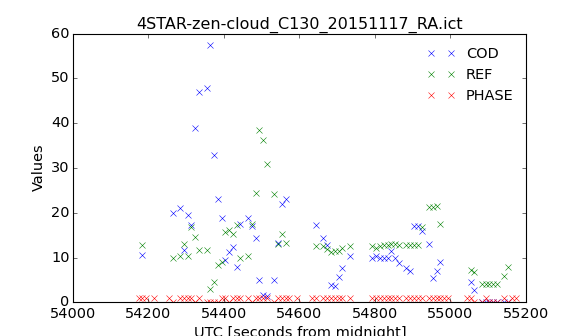

plotting the togethers


<IPython.core.display.Javascript object>


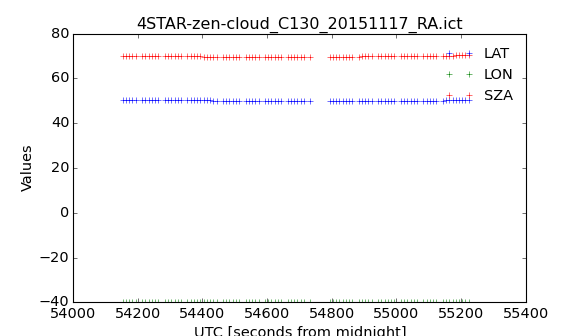

plotting the togethers 2


<IPython.core.display.Javascript object>


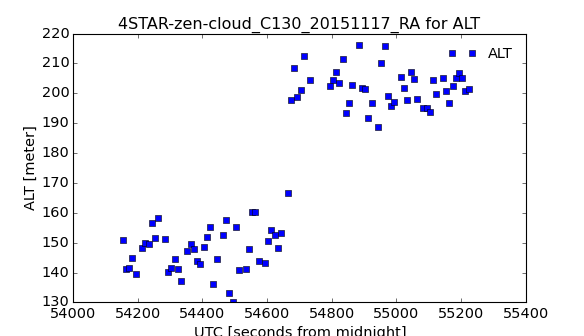

plotting ALT


In [154]:
wu.make_plots_ict(data_dict,filepath=fp+'plot/',data_id='4STAR-zen-cloud',loc_id='C130',date='20151117',rev='RA',
                  plot_together=['COD','REF','PHASE'],plot_together2=['LAT','LON','SZA'])

In [245]:
wu.write_ict(h_dict,data_dict,filepath=fp,data_id='4STAR-zen-cloud',loc_id='C130',date='20151117',rev='RA',order=order)

LAT
LON
ALT
SZA
COD
REF
PHASE
File writing successful to: C:/Users/sleblan2/Research/NAAMES/4STAR-zen-cloud_C130_20151117_RA.ict


### Redo for second day

In [178]:
d_dict2['LAT']

{'data': array([[ 47.6186],
        [ 47.6186],
        [ 47.6186],
        [ 47.6186],
        [ 47.6186],
        [ 47.6186],
        [ 47.6186],
        [ 47.6186],
        [ 42.4813],
        [ 42.475 ],
        [ 42.4682],
        [ 42.4567],
        [ 42.4449],
        [ 42.4339],
        [ 42.4244],
        [ 42.4174],
        [ 42.412 ],
        [ 42.4095],
        [ 42.4103],
        [ 42.4145],
        [ 42.4204],
        [ 42.4287],
        [ 42.4383],
        [ 42.4487],
        [ 42.4595],
        [ 42.4692],
        [ 42.4797],
        [ 42.49  ],
        [ 42.5003],
        [ 42.511 ],
        [ 42.5208],
        [ 42.5315],
        [ 42.5423],
        [ 42.5528],
        [ 42.5631],
        [ 42.5723],
        [ 42.5821],
        [ 42.5919],
        [ 42.6016],
        [ 42.6114],
        [ 42.6211],
        [ 42.6277],
        [ 42.635 ],
        [ 42.6415],
        [ 42.6512],
        [ 42.6609],
        [ 42.6707],
        [ 42.6806],
        [ 42.6897],
        [ 42

In [179]:
data_dict2 = wu.prep_data_for_ict(d_dict2,Start_UTC=12.65,End_UTC=13.8,time_interval=10.0)

In [180]:
data_dict2.keys()

['Start_UTC', 'SZA', 'LON', 'LAT', 'COD', 'PHASE', 'ALT', 'REF']

## Now prepare the same values but from MODIS

In [236]:
md_dict =  {'utc':{'data':star['utc'],'unit':'hours from midnight UTC',
                     'long_description':'Fractional hours starting a midnight, continuous'},
          'COD':{'data':modis['tau'][mod_ind[0,:],mod_ind[1,:]],'unit':'None','format':'.1f',
                 'long_description':'Cloud Optical Depth from MODIS'},
          'REF':{'data':modis['ref'][mod_ind[0,:],mod_ind[1,:]],'unit':'microns','format':'.1f',
                 'long_description':'Cloud particle effective radius, pertains to liquid cloud drops and ice crystals'},
          'PHASE':{'data':modis['phase'][mod_ind[0,:],mod_ind[1,:]],'unit':'None','format':'.0f',
                   'long_description':'Thermodynamic phase of cloud,'+\
                   ' 0 -- cloud free, 1 -- water cloud, 2 -- ice cloud, 3 -- mixed phase cloud, 6 -- undetermined phase'},
          'LAT':{'data':modis['lat'][mod_ind[0,:],mod_ind[1,:]],'unit':'Degrees','format':'.6f',
                 'long_description':'MODIS linked to Aircraft position latitude (North positive)'},
          'LON':{'data':modis['lon'][mod_ind[0,:],mod_ind[1,:]],'unit':'Degrees','format':'.6f',
                 'long_description':'MODIS linked to Aircraft position longitude (East positive)'},
          'SZA':{'data':star['sza'],'unit':'Degrees','format':'.2f',
                 'long_description':'Solar Zenith Angle, angle of the sun between it and zenith'}
          }

In [237]:
mh_dict ={'PI':'Samuel LeBlanc',
         'Institution':'NASA Ames Research Center',
         'Instrument':'MODIS',
         'campaign':'NAAMES #1',
         'special_comments':'MODIS retrieved cloud values linked along C130 flight path',
         'PI_contact':'Samuel LeBlanc, samuel.leblanc@nasa.gov',
         'platform':'C130',
         'location':"based out of St-John's, NL, Canada, actual location of C130 described by lat and lon below",
         'instrument_info':'Retrieved products from the MODIS, MYD06_L2.A2015321.1540.006.2015322185040.hdf',
         'data_info':'For references see LeBlanc et al.(2015) AMT, doi:10.5194/amt-8-1361-2015',
         'time_interval':10.0,
         'uncertainty':'N\A',
         'DM_contact':'Samuel LeBlanc, samuel.leblanc@nasa.gov',
         'project_info':'NAAMES field mission',
         'stipulations':'Prior OK from PI',
         'rev_comments':"""RA: initial go at this, for radiative transfer calculations"""
        }

In [238]:
order=['LAT','LON','SZA','COD','REF','PHASE']

In [239]:
mdata_dict = wu.prep_data_for_ict(md_dict,Start_UTC=15.04,End_UTC=15.34,time_interval=10.0)

In [250]:
wu.write_ict(mh_dict,mdata_dict,filepath=fp,data_id='MODIS-cloud-to-C130',loc_id='C130',date='20151117',rev='RA',order=order)

LAT
LON
SZA
COD
REF
PHASE
File writing successful to: C:/Users/sleblan2/Research/NAAMES/MODIS-cloud-to-C130_C130_20151117_RA.ict


### Redo MODIS but for the second day

In [ ]:
mod_ind2b = mod_ind2.copy()
mod_ind2b[0,13:] = mod_ind2b[0,13:]-3
mod_ind2b[1,13:] = mod_ind2b[1,13:]-3

In [217]:
md_dict2 =  {'utc':{'data':star2['utc'],'unit':'hours from midnight UTC',
                     'long_description':'Fractional hours starting a midnight, continuous'},
          'COD':{'data':modis2['tau'][mod_ind2b[0,:],mod_ind2b[1,:]],'unit':'None','format':'.1f',
                 'long_description':'Cloud Optical Depth from MODIS'},
          'REF':{'data':modis2['ref'][mod_ind2b[0,:],mod_ind2b[1,:]],'unit':'microns','format':'.1f',
                 'long_description':'Cloud particle effective radius, pertains to liquid cloud drops and ice crystals'},
          'PHASE':{'data':modis2['phase'][mod_ind2b[0,:],mod_ind2b[1,:]],'unit':'None','format':'.0f',
                   'long_description':'Thermodynamic phase of cloud,'+\
                   ' 0 -- cloud free, 1 -- water cloud, 2 -- ice cloud, 3 -- mixed phase cloud, 6 -- undetermined phase'},
          'LAT':{'data':modis2['lat'][mod_ind2b[0,:],mod_ind2b[1,:]],'unit':'Degrees','format':'.6f',
                 'long_description':'MODIS linked to Aircraft position latitude (North positive)'},
          'LON':{'data':modis2['lon'][mod_ind2b[0,:],mod_ind2b[1,:]],'unit':'Degrees','format':'.6f',
                 'long_description':'MODIS linked to Aircraft position longitude (East positive)'},
          'SZA':{'data':star2['sza'],'unit':'Degrees','format':'.2f',
                 'long_description':'Solar Zenith Angle, angle of the sun between it and zenith'}
          }
mh_dict ={'PI':'Samuel LeBlanc',
         'Institution':'NASA Ames Research Center',
         'Instrument':'MODIS',
         'campaign':'NAAMES #1',
         'special_comments':'MODIS retrieved cloud values linked along C130 flight path',
         'PI_contact':'Samuel LeBlanc, samuel.leblanc@nasa.gov',
         'platform':'C130',
         'location':"based out of St-John's, NL, Canada, actual location of C130 described by lat and lon below",
         'instrument_info':'Retrieved products from the MODIS, MYD06_L2.A2015321.1540.006.2015322185040.hdf',
         'data_info':'For references see LeBlanc et al.(2015) AMT, doi:10.5194/amt-8-1361-2015',
         'time_interval':10.0,
         'uncertainty':'N\A',
         'DM_contact':'Samuel LeBlanc, samuel.leblanc@nasa.gov',
         'project_info':'NAAMES field mission',
         'stipulations':'Prior OK from PI',
         'rev_comments':"""RA: initial go at this, for radiative transfer calculations"""
        }
mdata_dict2 = wu.prep_data_for_ict(md_dict2,Start_UTC=12.65,End_UTC=13.8,time_interval=10.0)

## Now run through the same process for RSP

In [144]:
rsp.keys()

['COT_rad_1590',
 'Reff_rad_2260',
 'COT',
 'Reff_rad_1590',
 'UTC_stop',
 'Lon',
 'Veff_unc',
 'CTH_stereo',
 'Reff_unc',
 'COT_rad_2260',
 'Lat',
 'UTC_start',
 'Veff',
 'alt',
 'Reff']

<IPython.core.display.Javascript object>


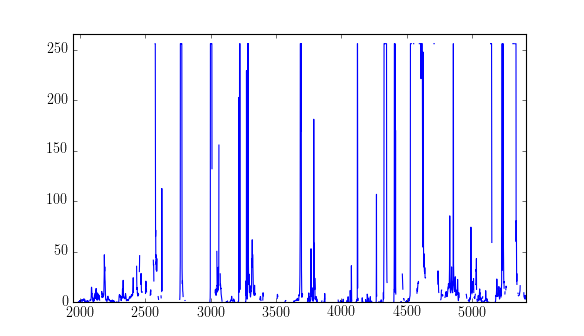

In [303]:
plt.figure()
plt.plot(rsp['COT'])

In [145]:
rd_dict =  {'utc':{'data':rsp['UTC_start']/3600.0,'unit':'hours from midnight UTC',
                     'long_description':'Fractional hours starting a midnight, continuous'},
          'COD':{'data':rsp['COT'],'unit':'None','format':'.1f',
                 'long_description':'Cloud Optical Depth from MODIS'},
          'REF':{'data':rsp['Reff'],'unit':'microns','format':'.1f',
                 'long_description':'Cloud particle effective radius, pertains to liquid cloud drops using polarimetric methods'},
          'PHASE':{'data':rsp['UTC_start']*0.0,'unit':'None','format':'.0f',
                   'long_description':'Thermodynamic phase of cloud,'+\
                   ' 0 -- cloud free, 1 -- water cloud, 2 -- ice cloud, 3 -- mixed phase cloud, 6 -- undetermined phase'},
          'LAT':{'data':rsp['Lat'],'unit':'Degrees','format':'.6f',
                 'long_description':'MODIS linked to Aircraft position latitude (North positive)'},
          'LON':{'data':rsp['Lon'],'unit':'Degrees','format':'.6f',
                 'long_description':'MODIS linked to Aircraft position longitude (East positive)'},
          'SZA':{'data':(24.0-rsp['UTC_start']/3600.0)*3.0,'unit':'Degrees','format':'.2f',
                 'long_description':'Solar Zenith Angle, angle of the sun between it and zenith'}
          }
rh_dict ={'PI':'Samuel LeBlanc',
         'Institution':'NASA Ames Research Center',
         'Instrument':'RSP',
         'campaign':'NAAMES #1',
         'special_comments':'MODIS retrieved cloud values linked along C130 flight path',
         'PI_contact':'Samuel LeBlanc, samuel.leblanc@nasa.gov',
         'platform':'C130',
         'location':"based out of St-John's, NL, Canada, actual location of C130 described by lat and lon below",
         'instrument_info':'Retrieved products from the RSP, ',
         'data_info':'For references see LeBlanc et al.(2015) AMT, doi:10.5194/amt-8-1361-2015',
         'time_interval':10.0,
         'uncertainty':'N\A',
         'DM_contact':'Samuel LeBlanc, samuel.leblanc@nasa.gov',
         'project_info':'NAAMES field mission',
         'stipulations':'Prior OK from PI',
         'rev_comments':"""RA: initial go at this, for radiative transfer calculations"""
        }
rdata_dict = wu.prep_data_for_ict(rd_dict,Start_UTC=14.6,End_UTC=16.55,time_interval=10.0)

### And for the second day of RSP

In [146]:
rd_dict2 =  {'utc':{'data':rsp2['UTC_start']/3600.0,'unit':'hours from midnight UTC',
                     'long_description':'Fractional hours starting a midnight, continuous'},
          'COD':{'data':rsp2['COT'],'unit':'None','format':'.1f',
                 'long_description':'Cloud Optical Depth from MODIS'},
          'REF':{'data':rsp2['Reff'],'unit':'microns','format':'.1f',
                 'long_description':'Cloud particle effective radius, pertains to liquid cloud drops using polarimetric methods'},
          'PHASE':{'data':rsp2['UTC_start']*0.0,'unit':'None','format':'.0f',
                   'long_description':'Thermodynamic phase of cloud,'+\
                   ' 0 -- cloud free, 1 -- water cloud, 2 -- ice cloud, 3 -- mixed phase cloud, 6 -- undetermined phase'},
          'LAT':{'data':rsp2['Lat'],'unit':'Degrees','format':'.6f',
                 'long_description':'MODIS linked to Aircraft position latitude (North positive)'},
          'LON':{'data':rsp2['Lon'],'unit':'Degrees','format':'.6f',
                 'long_description':'MODIS linked to Aircraft position longitude (East positive)'},
          'SZA':{'data':(24.0-rsp2['UTC_start']/3600.0)*3.0,'unit':'Degrees','format':'.2f',
                 'long_description':'Solar Zenith Angle, angle of the sun between it and zenith'}
          }
rdata_dict2 = wu.prep_data_for_ict(rd_dict2,Start_UTC=12.1,End_UTC=12.43,time_interval=10.0)

# Prepare input files for radiative transfer

In [149]:
import Run_libradtran as Rl

## Prepare the files for the first day

### Prepare the defaults

In [150]:
from datetime import datetime
datetime(2015,11,17).timetuple().tm_yday

321

In [151]:
geo = {'lat':47.6212167,'lon':52.74245,'doy':321,'zout':[0,100.0]}
aero = {} # none
cloud = {'ztop':2.5,'zbot':2.0,'write_moments_file':False}
source = {'wvl_range':[201.0,4000.0],'source':'solar','integrate_values':True,'run_fuliou':True,
          'dat_path':'/u/sleblan2/libradtran/libRadtran-2.0-beta/data/'}
albedo = {'create_albedo_file':False,'sea_surface_albedo':True,'wind_speed':10.0}

In [152]:
cloud['phase'] = 'wc'
geo['sza'] = 40.0
cloud['tau'] = 2.0
cloud['ref'] = 5.0

In [153]:
phase_star = {0:'wc',1:'ic'}

In [154]:
phase_modis = {0:'wc',1:'wc',2:'ic',3:'ic',6:'wc'}

### Make the runs for 4STAR

In [251]:
data_dict['COD']['data']

array([    nan,     nan,     nan,     nan,  10.5  ,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,  20.   ,     nan,
        21.   ,  11.75 ,  19.5  ,  17.375,  38.875,  46.875,     nan,
        47.875,  57.5  ,  32.875,  23.   ,  18.75 ,   9.375,  11.25 ,
        12.375,   7.875,  17.5  ,     nan,  18.75 ,  17.125,  14.375,
         5.   ,   1.575,   1.325,     nan,   5.075,  13.2  ,  21.875,
        23.   ,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,  17.25 ,     nan,  14.375,  12.8  ,   3.8  ,   3.55 ,
         5.675,   7.75 ,     nan,  10.25 ,     nan,     nan,     nan,
           nan,     nan,  10.   ,  10.25 ,  10.   ,  10.   ,  10.   ,
        11.5  ,  10.   ,   8.75 ,     nan,   7.75 ,   7.   ,  17.   ,
        17.   ,  15.875,     nan,  13.   ,   5.5  ,   7.   ,   9.125,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
         4.55 ,   2.825,     nan,     nan,     nan,     nan,     nan,
           nan,     

In [252]:
data_dict['PHASE']['data']

array([ nan,  nan,  nan,   1.,   1.,   1.,  nan,   1.,  nan,  nan,  nan,
         1.,   0.,  nan,   1.,   1.,   1.,   1.,   0.,   1.,  nan,   0.,
         0.,   0.,   0.,   1.,   1.,   0.,   1.,   1.,   1.,  nan,   1.,
         0.,   1.,   1.,   1.,   1.,  nan,   0.,   1.,   1.,   1.,   1.,
        nan,   1.,  nan,  nan,  nan,   1.,   1.,  nan,   1.,   1.,   1.,
         1.,   1.,   1.,  nan,   1.,  nan,  nan,  nan,  nan,  nan,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,  nan,   1.,   1.,   1.,
         1.,   1.,  nan,   1.,   1.,   1.,   1.,   1.,   1.,  nan,  nan,
        nan,  nan,   1.,   1.,   0.,  nan,   0.,   1.,   0.,   0.,   0.,
        nan,   1.,   0.,   1.,   1.,  nan,  nan,  nan,  nan,  nan])

In [253]:
data_dict['REF']['data']

array([   nan,    nan,    nan,    nan,  12.75,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,  10.  ,    nan,  10.25,  13.  ,
        10.25,  16.75,  14.5 ,  11.75,    nan,  11.75,   3.  ,   4.5 ,
         8.25,   9.  ,  15.75,  16.25,  15.25,  17.25,  10.  ,    nan,
        10.25,  17.5 ,  24.5 ,  38.5 ,  36.25,  31.  ,    nan,  24.25,
        13.  ,  15.25,  13.25,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,  12.5 ,    nan,  12.5 ,  12.  ,  11.25,  11.5 ,
        11.5 ,  12.25,    nan,  12.5 ,    nan,    nan,    nan,    nan,
          nan,  12.5 ,  12.25,  12.5 ,  12.75,  12.75,  13.  ,  13.  ,
        12.75,    nan,  12.75,  12.75,  12.75,  12.75,  16.75,    nan,
        21.25,  21.25,  21.5 ,  17.5 ,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,   7.25,   6.75,    nan,   4.  ,   4.  ,
         4.  ,   4.  ,   4.  ,    nan,   6.  ,   8.  ,    nan,    nan,
          nan,    nan,    nan,    nan,    nan])

In [269]:
# open the list file
f = open(fp+'rtm/NAAMES_20151117_CRE.sh','w')
fpp_in = '/nobackup/sleblan2/rtm/input/NAAMES_CRE_20151117/'
fpp_out = '/nobackup/sleblan2/rtm/output/NAAMES_CRE_20151117/'
fp_uv = '/u/sleblan2/libradtran/libRadtran-2.0-beta/bin/uvspec'
fp_in = fp+'rtm/input/CRE/'

In [270]:
for i,l in enumerate(data_dict['LAT']['data']):
    if l<-100.: # for only valid values
        continue
    if not np.isfinite(data_dict['PHASE']['data'][i]) or not np.isfinite(data_dict['COD']['data'][i]):
        continue
    print i
    
    f_in = 'NAAMES_v1_star_{:03d}.dat'.format(i)
    geo['lat'],geo['lon'],geo['sza'] = l,data_dict['LON']['data'][i],data_dict['SZA']['data'][i]
    cloud['tau'],cloud['ref'] = data_dict['COD']['data'][i],data_dict['REF']['data'][i]
    cloud['phase'] = phase_star[data_dict['PHASE']['data'][i]]
    Rl.write_input_aac(fp_in+f_in,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                               verbose=False,make_base=False,set_quiet=True)
    f.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+f_in,out=fpp_out+f_in))
    
    f_in = 'NAAMES_v1_star_{:03d}_clear.dat'.format(i)
    cloud['tau'] = 0.0
    Rl.write_input_aac(fp_in+f_in,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                               verbose=False,make_base=False,set_quiet=True)
    f.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+f_in,out=fpp_out+f_in))
f.close()

4
12
14
15
16
17
18
19
21
22
23
24
25
26
27
28
29
30
32
33
34
35
36
37
39
40
41
42
50
52
53
54
55
56
57
59
65
66
67
68
69
70
71
72
74
75
76
77
78
80
81
82
83
91
92


C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


### Make the runs for MODIS

In [271]:
# open the list file
fm = open(fp+'rtm/NAAMES_20151117_CRE_modis.sh','w')
fpp_in = '/nobackup/sleblan2/rtm/input/NAAMES_CRE_20151117/'
fpp_out = '/nobackup/sleblan2/rtm/output/NAAMES_CRE_20151117/'
fp_uv = '/u/sleblan2/libradtran/libRadtran-2.0-beta/bin/uvspec'
fp_in = fp+'rtm/input/CRE/'

In [272]:
for i,l in enumerate(mdata_dict['LAT']['data']):
    if l<-100.: # for only valid values
        continue
    if not np.isfinite(mdata_dict['PHASE']['data'][i]) or not np.isfinite(mdata_dict['COD']['data'][i]):
        continue
    print i
    
    f_in = 'NAAMES_v1_modis_{:03d}.dat'.format(i)
    geo['lat'],geo['lon'],geo['sza'] = l,mdata_dict['LON']['data'][i],mdata_dict['SZA']['data'][i]
    cloud['tau'],cloud['ref'] = mdata_dict['COD']['data'][i],mdata_dict['REF']['data'][i]
    cloud['phase'] = phase_modis[mdata_dict['PHASE']['data'][i]]
    Rl.write_input_aac(fp_in+f_in,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                               verbose=False,make_base=False,set_quiet=True)
    fm.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+f_in,out=fpp_out+f_in))
    
    f_in = 'NAAMES_v1_modis_{:03d}_clear.dat'.format(i)
    cloud['tau'] = 0.0
    Rl.write_input_aac(fp_in+f_in,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                               verbose=False,make_base=False,set_quiet=True)
    fm.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+f_in,out=fpp_out+f_in))
fm.close()

4
12
14
15
16
17
18
19
21
22
23
24
25
26
28
32
33
34
35
40
41
42
43
45
46
47
48
55
65
66
68
71
76
77
78
80
81
82
83
84
85
87
92
94
95
96
100
103
104
105
106
107
108


C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


### Make the runs for RSP

In [155]:
# open the list file
fm = open(fp+'rtm/NAAMES_20151117_CRE_rsp.sh','w')
fpp_in = '/nobackup/sleblan2/rtm/input/NAAMES_CRE_20151117/'
fpp_out = '/nobackup/sleblan2/rtm/output/NAAMES_CRE_20151117/'
fp_uv = '/u/sleblan2/libradtran/libRadtran-2.0-beta/bin/uvspec'
fp_in = fp+'rtm/input/CRE/'

In [156]:
for i,l in enumerate(rdata_dict['LAT']['data']):
    if l<-100.: # for only valid values
        continue
    if not np.isfinite(rdata_dict['PHASE']['data'][i]) or not np.isfinite(rdata_dict['COD']['data'][i]):
        continue
    print i
    
    f_in = 'NAAMES_v1_rsp_{:03d}.dat'.format(i)
    geo['lat'],geo['lon'],geo['sza'] = l,rdata_dict['LON']['data'][i],rdata_dict['SZA']['data'][i]
    cloud['tau'],cloud['ref'] = rdata_dict['COD']['data'][i],rdata_dict['REF']['data'][i]
    cloud['phase'] = 'wc' #phase_modis[rdata_dict['PHASE']['data'][i]]
    Rl.write_input_aac(fp_in+f_in,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                               verbose=False,make_base=False,set_quiet=True)
    fm.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+f_in,out=fpp_out+f_in))
    
    f_in = 'NAAMES_v1_rsp_{:03d}_clear.dat'.format(i)
    cloud['tau'] = 0.0
    Rl.write_input_aac(fp_in+f_in,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                               verbose=False,make_base=False,set_quiet=True)
    fm.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+f_in,out=fpp_out+f_in))
fm.close()

419
wvl_range starting too low, setting to 250 nm
420
422
423
424
425
426
427
428
429
430
431
445
447
448
449
450
451
453
454
455
457
458
461
464
466
467
468
469
470
471
635
637
642
643
644
645
646
648
649
650
651
652
660
661
662
663
664
667
668
669
670
672
673
675
676
679
680
681
682
683


## Prepare the files for the second day

### Prepare the defaults

In [157]:
datetime(2015,11,23).timetuple().tm_yday

327

In [158]:
geo = {'lat':42.78,'lon':-40.0,'doy':327,'zout':[0,100.0]}
aero = {} # none
cloud = {'ztop':2.5,'zbot':2.0,'write_moments_file':False}
source = {'wvl_range':[201.0,4000.0],'source':'solar','integrate_values':True,'run_fuliou':True,
          'dat_path':'/u/sleblan2/libradtran/libRadtran-2.0-beta/data/'}
albedo = {'create_albedo_file':False,'sea_surface_albedo':True,'wind_speed':10.0}

In [159]:
cloud['phase'] = 'wc'
geo['sza'] = 40.0
cloud['tau'] = 2.0
cloud['ref'] = 5.0

### Prepare the 4STAR data

In [182]:
# open the list file
f = open(fp+'rtm/NAAMES_20151123_CRE.sh','w')
fpp_in = '/nobackup/sleblan2/rtm/input/NAAMES_CRE_20151123/'
fpp_out = '/nobackup/sleblan2/rtm/output/NAAMES_CRE_20151123/'
fp_uv = '/u/sleblan2/libradtran/libRadtran-2.0-beta/bin/uvspec'
fp_in = fp+'rtm/input/CRE/'

In [183]:
for i,l in enumerate(data_dict2['LAT']['data']):
    if l<-100.: # for only valid values
        continue
    if not np.isfinite(data_dict2['PHASE']['data'][i]) or not np.isfinite(data_dict2['COD']['data'][i]):
        continue
    print i
    
    f_in = 'NAAMES_v1_star2_{:03d}.dat'.format(i)
    geo['lat'],geo['lon'],geo['sza'] = l,data_dict2['LON']['data'][i],data_dict2['SZA']['data'][i]
    cloud['tau'],cloud['ref'] = data_dict2['COD']['data'][i],data_dict2['REF']['data'][i]
    cloud['phase'] = phase_star[data_dict2['PHASE']['data'][i]]
    Rl.write_input_aac(fp_in+f_in,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                               verbose=False,make_base=False,set_quiet=True)
    f.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+f_in,out=fpp_out+f_in))
    
    f_in = 'NAAMES_v1_star2_{:03d}_clear.dat'.format(i)
    cloud['tau'] = 0.0
    Rl.write_input_aac(fp_in+f_in,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                               verbose=False,make_base=False,set_quiet=True)
    f.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+f_in,out=fpp_out+f_in))
f.close()

41
wvl_range starting too low, setting to 250 nm
43
44
45
46
47
49
50
51
52
53
54
56
57
58
59
60
64
65
66
68
69
70
71
79
81
82
89
90
91
92
94
95
96
97
98
100
101
102
103
104
106
107
108
109
117
119
120
121
122
123
125
126
127
128
129
130
132
133
134
135
136
138
139
140
141
142
144
145
146
147
155
157
158
159
160
161
163
164
165
166
167
168
170
171
172
173
174
176
177
178
179
180
182
183
185
193
195
196
197
198
199
201
202
203
204
205
206
209
210
211
212
214
215
216
217
218
220
221
222
223
231
233
234
235
236
237
239
240
241
242
243
244
246
247
248
249
250
252
253
254
255
256
258
259
260


C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


### Prepare MODIS data

In [226]:
fm = open(fp+'rtm/NAAMES_20151123_CRE_modis.sh','w')

In [219]:
mdata_dict2['LAT']['data']

array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,  42.47191238,
        42.46385574,          nan,  42.44591522,  42.44987869,
        42.39360046,  42.37957001,  42.35793304,          nan,
        42.36380386,  42.36206436,  42.36206436,  42.35412598,
        42.37427139,  42.38821793,          nan,  42.38821793,
        42.45796204,  42.43006134,  42.43006134,  42.43006134,
                nan,  42.44401169,  42.46208954,  42.46208954,
        42.47603989,  42.48999023,  42.50394058,          nan,
        42.50394058,  42.51789093,  42.53184128,  42.53806305,
        42.52994156,          nan,  42.56416702,  42.56

In [227]:
for i,l in enumerate(mdata_dict2['LAT']['data']):
    if l<-100.: # for only valid values
        continue
    if not np.isfinite(mdata_dict2['PHASE']['data'][i]) or not np.isfinite(mdata_dict2['COD']['data'][i]):
        continue
    print i
    
    f_in = 'NAAMES_v1_modis2_{:03d}.dat'.format(i)
    geo['lat'],geo['lon'],geo['sza'] = l,mdata_dict2['LON']['data'][i],mdata_dict2['SZA']['data'][i]
    cloud['tau'],cloud['ref'] = mdata_dict2['COD']['data'][i],mdata_dict2['REF']['data'][i]
    cloud['phase'] = phase_modis[mdata_dict2['PHASE']['data'][i]]
    Rl.write_input_aac(fp_in+f_in,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                               verbose=False,make_base=False,set_quiet=True)
    fm.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+f_in,out=fpp_out+f_in))
    
    f_in = 'NAAMES_v1_modis2_{:03d}_clear.dat'.format(i)
    cloud['tau'] = 0.0
    Rl.write_input_aac(fp_in+f_in,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                               verbose=False,make_base=False,set_quiet=True)
    fm.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+f_in,out=fpp_out+f_in))
fm.close()

27
31
32
33
34
36
37
38
39
40
41
43
44
91
92
94
95
96
140
141
142
144
151
158
164
198
239
240
241
242
382
389
390
391
393
394


C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


### Prepare RSP data

In [224]:
# open the list file
fm = open(fp+'rtm/NAAMES_20151123_CRE_rsp.sh','w')


In [225]:
for i,l in enumerate(rdata_dict2['LAT']['data']):
    if l<-100.: # for only valid values
        continue
    if not np.isfinite(rdata_dict2['PHASE']['data'][i]) or not np.isfinite(rdata_dict2['COD']['data'][i]):
        continue
    print i
    
    f_in = 'NAAMES_v1_rsp2_{:03d}.dat'.format(i)
    geo['lat'],geo['lon'],geo['sza'] = l,rdata_dict2['LON']['data'][i],rdata_dict2['SZA']['data'][i]
    cloud['tau'],cloud['ref'] = rdata_dict2['COD']['data'][i],rdata_dict2['REF']['data'][i]
    cloud['phase'] = 'wc' #phase_modis[rdata_dict['PHASE']['data'][i]]
    Rl.write_input_aac(fp_in+f_in,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                               verbose=False,make_base=False,set_quiet=True)
    fm.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+f_in,out=fpp_out+f_in))
    
    f_in = 'NAAMES_v1_rsp2_{:03d}_clear.dat'.format(i)
    cloud['tau'] = 0.0
    Rl.write_input_aac(fp_in+f_in,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                               verbose=False,make_base=False,set_quiet=True)
    fm.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+f_in,out=fpp_out+f_in))
fm.close()

2
3
4
5
7
10
13
15
16
17
18
21
22
26
27
28
32
41
42
60
63
67
69
71
73
76
77
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
105
106
107
109
110
111
112


# Read the output files (after running on pleaides) and get CRE

## Read the files

In [240]:
nstar = len(data_dict['LAT']['data'])
nmodis = len(mdata_dict['LAT']['data'])
nrsp = len(rdata_dict['LAT']['data'])
star_CRE = {'dn':np.zeros((nstar,2))+np.nan,'up':np.zeros((nstar,2))+np.nan}
star_CRE_clear = {'dn':np.zeros((nstar,2))+np.nan,'up':np.zeros((nstar,2))+np.nan}
modis_CRE = {'dn':np.zeros((nmodis,2))+np.nan,'up':np.zeros((nmodis,2))+np.nan}
modis_CRE_clear = {'dn':np.zeros((nmodis,2))+np.nan,'up':np.zeros((nmodis,2))+np.nan}
rsp_CRE = {'dn':np.zeros((nrsp,2))+np.nan,'up':np.zeros((nrsp,2))+np.nan}
rsp_CRE_clear = {'dn':np.zeros((nrsp,2))+np.nan,'up':np.zeros((nrsp,2))+np.nan}
star_C = np.zeros((nstar,2))+np.nan
modis_C = np.zeros((nmodis,2))+np.nan
rsp_C = np.zeros((nrsp,2))+np.nan

In [244]:
print 'MODIS'
for i,l in enumerate(mdata_dict['LAT']['data']):
    if l<-100.: # for only valid values
        continue
    if not np.isfinite(mdata_dict['PHASE']['data'][i]) or not np.isfinite(mdata_dict['COD']['data'][i]):
        continue
    print '\r{}..'.format(i)
    f_in = 'NAAMES_v1_modis_{:03d}.dat'.format(i)
    s = Rl.read_libradtran(fp+'rtm/output/CRE/'+f_in,zout=[0,100])
    f_in = 'NAAMES_v1_modis_{:03d}_clear.dat'.format(i)
    sc = Rl.read_libradtran(fp+'rtm/output/CRE/'+f_in,zout=[0,100])
    
    modis_CRE['dn'][i,:] = s['diffuse_down']+s['direct_down']
    modis_CRE_clear['dn'][i,:] = sc['diffuse_down']+sc['direct_down']
    modis_CRE['up'][i,:] = s['diffuse_up']
    modis_CRE_clear['up'][i,:] = sc['diffuse_up']
    modis_C[i,:] = (modis_CRE['dn'][i,:]-modis_CRE['up'][i,:]) - (modis_CRE_clear['dn'][i,:]-modis_CRE_clear['up'][i,:])

MODIS
4..
12..
14..
15..
16..
17..
18..
19..
21..
22..
23..
24..
25..
26..
28..
32..
33..
34..
35..
40..
41..
42..
43..
45..
46..
47..
48..
55..
65..
66..
68..
71..
76..
77..
78..
80..
81..
82..
83..
84..
85..
87..
92..
94..
95..
96..
100..
103..
104..
105..
106..
107..
108..


C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


In [245]:
print '4STAR'
for i,l in enumerate(data_dict['LAT']['data']):
    if l<-100.: # for only valid values
        continue
    if not np.isfinite(data_dict['PHASE']['data'][i]) or not np.isfinite(data_dict['COD']['data'][i]):
        continue
    print '\r{}..'.format(i)
    f_in = 'NAAMES_v1_star_{:03d}.dat'.format(i)
    s = Rl.read_libradtran(fp+'rtm/output/CRE/'+f_in,zout=[0,100])
    f_in = 'NAAMES_v1_star_{:03d}_clear.dat'.format(i)
    sc = Rl.read_libradtran(fp+'rtm/output/CRE/'+f_in,zout=[0,100])
    
    star_CRE['dn'][i,:] = s['diffuse_down']+s['direct_down']
    star_CRE_clear['dn'][i,:] = sc['diffuse_down']+sc['direct_down']
    star_CRE['up'][i,:] = s['diffuse_up']
    star_CRE_clear['up'][i,:] = sc['diffuse_up']
    star_C[i,:] = (star_CRE['dn'][i,:]-star_CRE['up'][i,:]) - (star_CRE_clear['dn'][i,:]-star_CRE_clear['up'][i,:])

4STAR
4..
12..
14..
15..
16..
17..
18..
19..
21..
22..
23..
24..
25..
26..
27..
28..
29..
30..
32..
33..
34..
35..
36..
37..
39..
40..
41..
42..
50..
52..
53..
54..
55..
56..
57..
59..
65..
66..
67..
68..
69..
70..
71..
72..
74..
75..
76..
77..
78..
80..
81..
82..
83..
91..
92..


C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


In [277]:
print 'RSP'
for i,l in enumerate(rdata_dict['LAT']['data']):
    if l<-100.: # for only valid values
        continue
    if not np.isfinite(rdata_dict['PHASE']['data'][i]) or not np.isfinite(rdata_dict['COD']['data'][i]):
        continue
    print '\r{}..'.format(i)
    f_in = r'NAAMES_v1_rsp_{:03d}.dat'.format(i)
    try:
        s = Rl.read_libradtran(fp+'rtm/output/CRE/'+f_in,zout=[0,100])
    except:
        continue
    f_in = r'NAAMES_v1_rsp_{:03d}_clear.dat'.format(i)
    sc = Rl.read_libradtran(fp+'rtm/output/CRE/'+f_in,zout=[0,100])
    
    rsp_CRE['dn'][i,:] = s['diffuse_down']+s['direct_down']
    rsp_CRE_clear['dn'][i,:] = sc['diffuse_down']+sc['direct_down']
    rsp_CRE['up'][i,:] = s['diffuse_up']
    rsp_CRE_clear['up'][i,:] = sc['diffuse_up']
    rsp_C[i,:] = (rsp_CRE['dn'][i,:]-rsp_CRE['up'][i,:]) - (rsp_CRE_clear['dn'][i,:]-rsp_CRE_clear['up'][i,:])

RSP
419..
420..
422..
423..
424..
425..
426..
427..
428..
429..
430..
431..
445..
447..
448..
449..
450..
451..
453..
454..
455..
457..
458..
461..
464..
466..
467..
468..
469..
470..
471..
635..
637..
642..
643..
644..
645..
646..
648..
649..
650..
651..
652..
660..
661..
662..
663..
664..
667..
668..
669..
670..
672..
673..
675..
676..
679..
680..
681..
682..
683..


In [292]:
np.where(rsp_C[:,0]<-900)

C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


(array([461, 681, 682], dtype=int64),)

In [301]:
rdata_dict['COD']['data'][461]

256.0025

In [297]:
rsp_CRE['dn'][461,0]

28.206299999999999

In [301]:
star_CRE

{'dn': array([[          nan,           nan],
        [          nan,           nan],
        [          nan,           nan],
        [          nan,           nan],
        [  98.39539   ,  481.16823595],
        [          nan,           nan],
        [          nan,           nan],
        [          nan,           nan],
        [          nan,           nan],
        [          nan,           nan],
        [          nan,           nan],
        [          nan,           nan],
        [  83.25565   ,  482.30003652],
        [          nan,           nan],
        [  59.45315   ,  482.46863688],
        [  91.53443   ,  482.63943612],
        [  63.18097   ,  482.8091368 ],
        [  69.22213   ,  482.97423662],
        [  50.86608   ,  483.11673729],
        [  29.13541   ,  483.28173762],
        [          nan,           nan],
        [  41.57224   ,  483.44433751],
        [  27.26632   ,  483.60683787],
        [  49.62674   ,  483.77333734],
        [  73.84207   ,  483.87303

## Present CRE

In [302]:
star_C

array([[          nan,           nan],
       [          nan,           nan],
       [          nan,           nan],
       [          nan,           nan],
       [-218.425782  , -209.81833527],
       [          nan,           nan],
       [          nan,           nan],
       [          nan,           nan],
       [          nan,           nan],
       [          nan,           nan],
       [          nan,           nan],
       [          nan,           nan],
       [-233.53963   , -226.98490469],
       [          nan,           nan],
       [-255.982727  , -245.57538439],
       [-226.067899  , -216.44416516],
       [-252.770643  , -242.72639448],
       [-247.267799  , -232.23246466],
       [-264.58566   , -249.46612402],
       [-285.03782   , -270.01379369],
       [          nan,           nan],
       [-273.554504  , -259.67577379],
       [-287.063577  , -285.93187344],
       [-266.271132  , -264.30698396],
       [-243.663192  , -238.01930449],
       [-253.072806  , -2

In [303]:
modis_C

array([[          nan,           nan],
       [          nan,           nan],
       [          nan,           nan],
       [          nan,           nan],
       [-132.73686889, -127.05323698],
       [          nan,           nan],
       [          nan,           nan],
       [          nan,           nan],
       [          nan,           nan],
       [          nan,           nan],
       [          nan,           nan],
       [          nan,           nan],
       [-236.47103   , -218.33790465],
       [          nan,           nan],
       [-216.312716  , -202.41588541],
       [-168.55491389, -163.12386623],
       [-164.63158757, -154.84879657],
       [-153.66671367, -144.83036685],
       [-170.80549245, -158.9529265 ],
       [-158.6461586 , -149.68689674],
       [          nan,           nan],
       [-150.32089311, -139.54317693],
       [-196.39863689, -188.97077585],
       [-249.499329  , -238.2102846 ],
       [-216.331447  , -207.72390515],
       [-176.15518199, -1

<IPython.core.display.Javascript object>


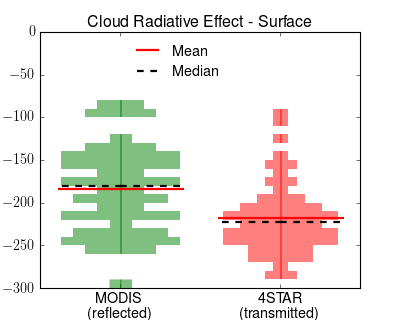

In [41]:
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[-300,0],xlim=[-0.5,1.5])
ax1.set_ylabel('Cloud Radiative Effect [W/m$^2$]')
ax1.set_title('Cloud Radiative Effect - Surface')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['MODIS\n(reflected)','4STAR\n(transmitted)'])
pu.plot_vert_hist(fig,ax1,modis_C[:,0],0,[-300,0],legend=True,onlyhist=False,loc=2,color='g',bins=30)
pu.plot_vert_hist(fig,ax1,star_C[:,0],1,[-300,0],legend=True,color='r',bins=30)
plt.savefig(fp+'plot/20151117_surface_CRE_modis_4STAR.png',transparent=True,dpi=600)

<IPython.core.display.Javascript object>


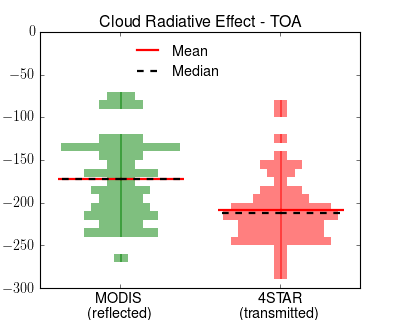

In [40]:
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[-300,0],xlim=[-0.5,1.5])
ax1.set_ylabel('Cloud Radiative Effect [W/m$^2$]')
ax1.set_title('Cloud Radiative Effect - TOA')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['MODIS\n(reflected)','4STAR\n(transmitted)'])
pu.plot_vert_hist(fig,ax1,modis_C[:,1],0,[-300,0],legend=True,onlyhist=False,loc=2,color='g',bins=30)
pu.plot_vert_hist(fig,ax1,star_C[:,1],1,[-300,0],legend=True,color='r',bins=30)
plt.savefig(fp+'plot/20151117_toa_CRE_modis_4STAR.png',transparent=True,dpi=600)

<IPython.core.display.Javascript object>


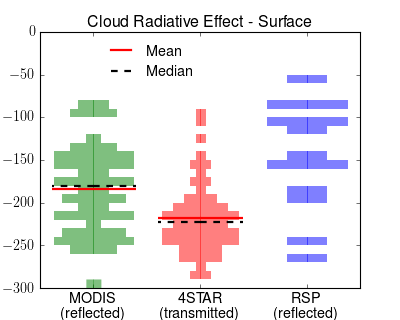

In [287]:
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[-300,0],xlim=[-0.5,2.5])
ax1.set_ylabel('Cloud Radiative Effect [W/m$^2$]')
ax1.set_title('Cloud Radiative Effect - Surface')
ax1.set_xticks([0,1,2])
ax1.set_xticklabels(['MODIS\n(reflected)','4STAR\n(transmitted)','RSP\n(reflected)'])
pu.plot_vert_hist(fig,ax1,modis_C[:,0],0,[-300,0],legend=True,onlyhist=False,loc=2,color='g',bins=30)
pu.plot_vert_hist(fig,ax1,star_C[:,0],1,[-300,0],legend=True,color='r',bins=30)
pu.plot_vert_hist(fig,ax1,rsp_C[:,0],2,[-300,0],legend=True,color='b',bins=30)
plt.savefig(fp+'plot/20151117_surface_CRE_modis_4STAR_rsp.png',transparent=True,dpi=600)

## Calculate the relative CRE and plot it

In [42]:
modis_rC = np.zeros_like(modis_C)
star_rC = np.zeros_like(star_C)

In [43]:
modis_rC[:,0] = modis_C[:,0]/modis_CRE['dn'][:,1]*100.0
star_rC[:,0] = star_C[:,0]/star_CRE['dn'][:,1]*100.0
modis_rC[:,1] = modis_C[:,1]/modis_CRE['dn'][:,1]*100.0
star_rC[:,1] = star_C[:,1]/star_CRE['dn'][:,1]*100.0

<IPython.core.display.Javascript object>


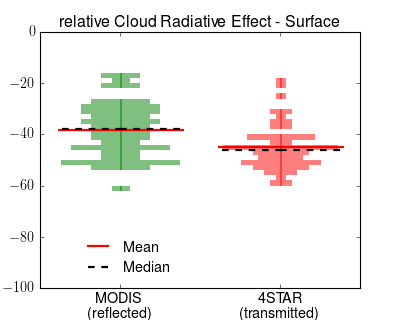

In [47]:
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[-100,0],xlim=[-0.5,1.5])
ax1.set_ylabel('relative Cloud Radiative Effect [\%]')
ax1.set_title('relative Cloud Radiative Effect - Surface')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['MODIS\n(reflected)','4STAR\n(transmitted)'])
pu.plot_vert_hist(fig,ax1,modis_rC[:,0],0,[-100,0],legend=True,onlyhist=False,loc=4,color='g',bins=50)
pu.plot_vert_hist(fig,ax1,star_rC[:,0],1,[-100,0],legend=True,color='r',bins=50)
plt.savefig(fp+'plot/20151117_surface_rCRE_modis_4STAR.png',transparent=True,dpi=600)

In [48]:
np.nanmean(modis_rC[:,0]),np.nanmean(star_rC[:,0])

(-38.258361004540518, -45.038011230987898)

In [51]:
np.nanstd(modis_rC[:,0]), np.nanstd(star_rC[:,0])

(10.328311579862529, 8.6292488844561817)

<IPython.core.display.Javascript object>


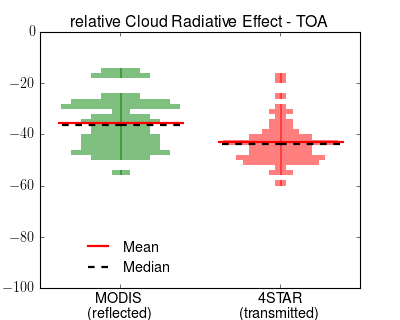

In [45]:
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[-100,0],xlim=[-0.5,1.5])
ax1.set_ylabel('relative Cloud Radiative Effect [%]')
ax1.set_title('relative Cloud Radiative Effect - TOA')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['MODIS\n(reflected)','4STAR\n(transmitted)'])
pu.plot_vert_hist(fig,ax1,modis_rC[:,1],0,[-100,0],legend=True,onlyhist=False,loc=4,color='g',bins=50)
pu.plot_vert_hist(fig,ax1,star_rC[:,1],1,[-100,0],legend=True,color='r',bins=50)
plt.savefig(fp+'plot/20151117_TOA_rCRE_modis_4STAR.png',transparent=True,dpi=600)